# Homework 4 - Group 20. Getting to know your customers

Group members:
* Giacomo Vittori
* Gianluca Frezza
* Jonas Barth

# Index (only works when opening with notebook)

- [Finding Similar Customers](#1.-Finding-Similar-Costumers)
    - [Set up the data](#1.1-Set-up-the-data)
    - [Fingerprint Hashing](#1.2-Fingerprint-hashing)
    - [Locality Sensitive Hashing](#1.3-Locality-Sensitive-Hashing)
- [Grouping Customers Together](#2.-Grouping-customers-together)
    - [Creating Feature Engineering](#2.1-Creating-feature-engineering)
    - [Reduce the Dimensionality](#2.2-Reduce-the-dimensionality)
    - [Clustering](#2.3-Clustering)
    - [Analysing Results](#2.4-Analysing-Results)
    - [Bonus Question](#Bonus-Question)
- [Algorithmic Question](#Algorithmic-Question)
## 1. Finding Similar Costumers

Companies nowadays are implementing product suggestions to provide users with things they are likely to buy. The process often starts by finding similar behaviours among consumers; for this task, we will focus on this part in the specific.
Here you will implement an algorithm to find the most similar match to a consumer given his bank account information. In particular, you will implement your version of the LSH algorithm that takes as input information about a consumer and finds people similar to the one in the study.

## 1.1 Set up the data

First of all we used pandas to import the dataset of transaction of a bank in India. The features that could be useful to match similar consumer given the bank accont information are: CustomerID, CustomerDOB (to group by similar ages), CustGender, CustAccountBalance (to group by richness) and TransactionAmount (to group by how much money they use). We didn't use the location in which the customer do the transaction and the time of it, but we'll keep the date to calculate the age.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm as tq
from math import sqrt
import seaborn as sn
from statistics import mean
import warnings
warnings.filterwarnings("ignore")

In [130]:
df = pd.read_csv('/Users/giacomo/Desktop/locale/bank_transactions.csv', usecols = ['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender', 'TransactionDate', 'CustAccountBalance', 'TransactionAmount (INR)'])

In [3]:
df.copy()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionDate,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,17819.05,2/8/16,25.0
1,T2,C2142763,4/4/57,M,2270.69,2/8/16,27999.0
2,T3,C4417068,26/11/96,F,17874.44,2/8/16,459.0
3,T4,C5342380,14/9/73,F,866503.21,2/8/16,2060.0
4,T5,C9031234,24/3/88,F,6714.43,2/8/16,1762.5
...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,7635.19,18/9/16,799.0
1048563,T1048564,C6459278,20/2/92,M,27311.42,18/9/16,460.0
1048564,T1048565,C6412354,18/5/89,M,221757.06,18/9/16,770.0
1048565,T1048566,C6420483,30/8/78,M,10117.87,18/9/16,1000.0


The dataset is composed by 1048567 transactions and 7 features referred to: TransactionID, CustomerID	CustomerDOB, CustGender, CustAccountBalance, TransactionDate, TransactionAmount (INR). Let's have a look into the missing values:

In [4]:
df.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustAccountBalance         2369
TransactionDate               0
TransactionAmount (INR)       0
dtype: int64

Given that the dataset is composed by 1048567 rows the missing values are a small percentage, so we decide to drop them: 

In [5]:
df = df.dropna()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041765 entries, 0 to 1048566
Data columns (total 7 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1041765 non-null  object 
 1   CustomerID               1041765 non-null  object 
 2   CustomerDOB              1041765 non-null  object 
 3   CustGender               1041765 non-null  object 
 4   CustAccountBalance       1041765 non-null  float64
 5   TransactionDate          1041765 non-null  object 
 6   TransactionAmount (INR)  1041765 non-null  float64
dtypes: float64(2), object(5)
memory usage: 63.6+ MB


# 1.1.1 Cust Gender

We started exploring the Gender of the customers:

In [7]:
type(df['CustGender'][0])

str

In [8]:
df['CustGender'].value_counts()

M    761098
F    280666
T         1
Name: CustGender, dtype: int64

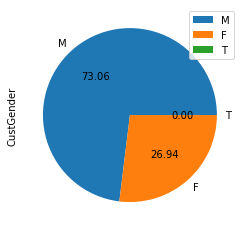

In [9]:
df['CustGender'].value_counts().plot(kind='pie', autopct='%.2f')

plt.legend()
 
plt.show()

We noticed that there is a 'T' classified gender in the dataset: 

In [10]:
df[df["CustGender"] == 'T'] 

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionDate,TransactionAmount (INR)
959987,T959988,C3380368,1/1/1800,T,50050.0,10/9/16,32500.0


Given the big amount of transactions that we have we decided to drop it, also considering that this customer have a missing value also for the DOB. 

In [11]:
df.drop(df[df.CustGender == 'T'].index, axis=0, inplace=True)

# 1.1.2 Age

We decided to convert into datetime the date of birthday of the customers and the date of the transaction:

In [12]:
print(type(df['CustomerDOB'][0]), type(df['TransactionDate'][0]))

<class 'str'> <class 'str'>


In [13]:
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'])

df['TransactionDate'] = pd.to_datetime(df['TransactionDate']) 

In [14]:
df.head(1)

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionDate,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,17819.05,2016-02-08,25.0


In [15]:
df['TransactionDate'].dt.year.value_counts()

2016    1041764
Name: TransactionDate, dtype: int64

In [16]:
df['TransactionDate'].dt.month.value_counts()

8     427368
9     157939
10     50742
7      48092
11     47036
4      46963
3      46755
6      45935
2      43510
12     42892
1      42460
5      42072
Name: TransactionDate, dtype: int64

All the data were taken in 2016, so we'll use this year to calculate the ages.
Going through the Date of Birthday we can see that there is something strange: there are dates of birthday referred to 1800, probably cause it is a default value when this data is missing, and a right tail that seems to be a part of the main figure with an offset: 

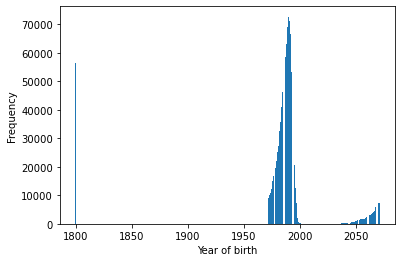

In [17]:
count = Counter(df['CustomerDOB'].dt.year)

plt.bar(count.keys(), count.values())

plt.xlabel('Year of birth')

plt.ylabel('Frequency')
 
plt.show()

In [18]:
df.loc[df['CustomerDOB'].dt.year == 1800]['CustomerDOB'].value_counts()

1800-01-01    56291
Name: CustomerDOB, dtype: int64

We decided to replace DOB referred to year 1800 with 0 age values and rearrange the data after year 2000 adjusting the offset.

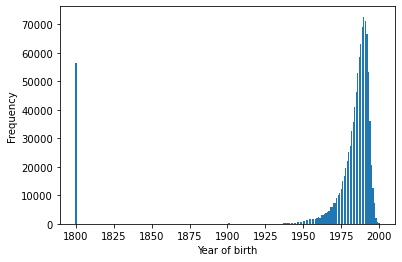

In [19]:
df.loc[df.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = df.loc[df.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

count = Counter(df['CustomerDOB'].dt.year)

plt.bar(count.keys(), count.values())

plt.xlabel('Year of birth')

plt.ylabel('Frequency')
 
plt.show()

We created a 'CustomerAge' column filling it with 0 values:

In [20]:
df['CustomerAge'] = 0 #initialize customerAge column with 0 values

Then we substitute ages that have YOB different from 1800:

In [21]:
df.loc[df['CustomerDOB'].dt.year != 1800, 'CustomerAge'] = df.loc[df['CustomerDOB'].dt.year != 1800, 'TransactionDate'].dt.year - df.loc[df['CustomerDOB'].dt.year != 1800, 'CustomerDOB'].dt.year 

In [22]:
df['CustomerAge'] = df['CustomerAge'].astype(int)

In [23]:
del df['TransactionDate']

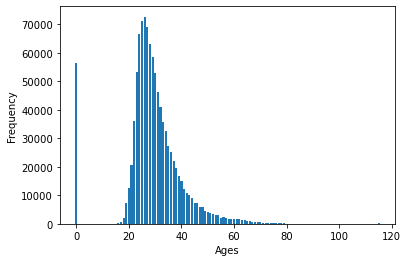

In [24]:
count = Counter(df['CustomerAge'])

plt.bar(count.keys(), count.values())

plt.xlabel('Ages')

plt.ylabel('Frequency')

plt.show()

Exploring the ages at the edges we can see that: 

In [25]:
df.loc[df['CustomerAge'] != 0]['CustomerAge'].min()

16

In [26]:
df['CustomerAge'].max()

115

Considering that the oldest person ever in India was Lucy d'Abreu who lived 113 years and 197 days (ref: Wikipedia) it seems a good choice to drop all the ages over 100 years.

In [27]:
df.drop(df[df.CustomerAge > 100].index, axis=0, inplace=True)

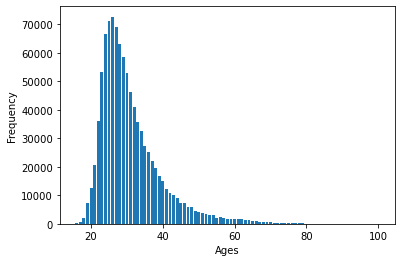

In [28]:
count = Counter(df['CustomerAge'])

count.pop(0, None)

plt.bar(count.keys(), count.values())

plt.xlabel('Ages')

plt.ylabel('Frequency')

plt.show()

In order to implement a Minhash function we decide to divide the CustomAge data in class of ages. Similar ages should led to similar interest. For this reason, looking at the distribution of ages and using our intuition, it seems to be a good choice to divide in class of 5 years from 16 to 101 (18 class):

In [29]:
bins = np.array(list(range(16, 102, 5))) #bins

def age(age):
    
    class_age = np.digitize(age, bins, right=False)  #return the number of the bin
    
    age = 'age_' + str(class_age) #class name
        
    return age

In [30]:
df['CustomerClassAge'] = df.CustomerAge.apply(lambda x: age(x)) #build the customerclass age column

In [31]:
df

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,CustomerClassAge
0,T1,C5841053,1994-10-01,F,17819.05,25.0,22,age_2
1,T2,C2142763,1957-04-04,M,2270.69,27999.0,59,age_9
2,T3,C4417068,1996-11-26,F,17874.44,459.0,20,age_1
3,T4,C5342380,1973-09-14,F,866503.21,2060.0,43,age_6
4,T5,C9031234,1988-03-24,F,6714.43,1762.5,28,age_3
...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,1990-08-04,M,7635.19,799.0,26,age_3
1048563,T1048564,C6459278,1992-02-20,M,27311.42,460.0,24,age_2
1048564,T1048565,C6412354,1989-05-18,M,221757.06,770.0,27,age_3
1048565,T1048566,C6420483,1978-08-30,M,10117.87,1000.0,38,age_5


Customer with age 0 (YOB 1800) are classified as 'CustomerClassAge' 0: 

In [32]:
df.loc[df['CustomerAge'] == 0]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,CustomerClassAge
16,T17,C1376215,1800-01-01,M,77495.15,1423.11,0,age_0
22,T23,C7018081,1800-01-01,M,143.07,110.00,0,age_0
28,T29,C7935438,1800-01-01,M,969436.12,36.90,0,age_0
35,T36,C1211387,1800-01-01,M,11791.25,1075.00,0,age_0
151,T152,C3334638,1800-01-01,M,700.00,1500.00,0,age_0
...,...,...,...,...,...,...,...,...
1048443,T1048444,C7261226,1800-01-01,M,1393.33,200.00,0,age_0
1048452,T1048453,C3813481,1800-01-01,M,984605.24,219.00,0,age_0
1048531,T1048532,C6937679,1800-01-01,M,50698.90,598.86,0,age_0
1048533,T1048534,C7431884,1800-01-01,M,53771.64,520.00,0,age_0


Age_0 will not be insterted into shingles, such that the one hot vector referred to a missing value of age will have only zeros and to not group as similar people with year of birthday 1800.

# 1.1.3 Different people with the same CustomerID

We decided to check the data related to transactions referred to the same CustomerID:

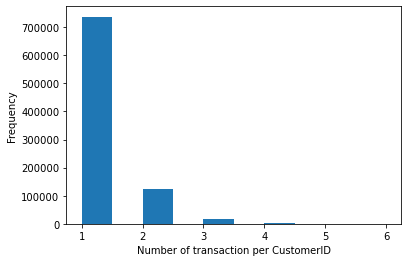

In [33]:
df.groupby('CustomerID').TransactionID.count().plot.hist()

plt.xlabel('Number of transaction per CustomerID')

plt.ylabel('Frequency')

plt.show()

In [34]:
a = df.groupby('CustomerID').TransactionID.count()  #series with number of transaction per CustomerID

df[df.CustomerID.isin(a[a > 1].index)].sort_values(by = "CustomerID") #same customer with more than one transaction

,TransactionID,CustomerID,CustomerDOB,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,CustomerClassAge
33670,T33671,C1010011,1992-08-19,F,32500.73,4750.00,24,age_2
173508,T173509,C1010011,1983-05-08,M,120180.54,356.00,33,age_4
251647,T251648,C1010014,1984-08-19,M,161848.76,250.00,32,age_4
89543,T89544,C1010014,1992-04-06,F,38377.14,1205.00,24,age_2
50880,T50881,C1010031,1984-07-21,M,1754.10,404.00,32,age_4
...,...,...,...,...,...,...,...,...
407803,T407804,C9094224,1980-06-24,F,10579.38,2458.00,36,age_5
673478,T673479,C9095886,1992-06-04,M,284.48,123.89,24,age_2
500536,T500537,C9095886,1991-06-19,F,27313.55,289.37,25,age_2
545604,T545605,C9096252,1991-04-03,M,9424.29,50.00,25,age_2


We can see that transactions addressed to the same CustomerID are instead related to different people but labeled with the same username. We can say that with high probability these kind of CustomerID are referred to a family or in general groups of people. We decided to threat them as different people defining a new ID based on original Customer ID, gender and ID: 

In [35]:
df['New_ID'] = df['CustomerID'] + df['CustGender'] + df['CustomerAge'].astype(str) #string concatenation

In [36]:
df[['New_ID', 'CustomerID', 'CustGender', 'CustomerAge']]

,New_ID,CustomerID,CustGender,CustomerAge
0,C5841053F22,C5841053,F,22
1,C2142763M59,C2142763,M,59
2,C4417068F20,C4417068,F,20
3,C5342380F43,C5342380,F,43
4,C9031234F28,C9031234,F,28
...,...,...,...,...
1048562,C8020229M26,C8020229,M,26
1048563,C6459278M24,C6459278,M,24
1048564,C6412354M27,C6412354,M,27
1048565,C6420483M38,C6420483,M,38


Now people labelled with same CustomerID but different ages and gender will be labelled with different CustomerID:

In [37]:
a = df.groupby('CustomerID').TransactionID.count()  #series with number of transaction per CustomerID

df[df.CustomerID.isin(a[a>1].index)][['CustomerID', 'New_ID']].sort_values(by="CustomerID") #same customer with more than one transaction

,CustomerID,New_ID
33670,C1010011,C1010011F24
173508,C1010011,C1010011M33
251647,C1010014,C1010014M32
89543,C1010014,C1010014F24
50880,C1010031,C1010031M32
...,...,...
407803,C9094224,C9094224F36
673478,C9095886,C9095886M24
500536,C9095886,C9095886F25
545604,C9096252,C9096252M25


We can see that the max number of transaction per person decreased:

In [38]:
df.groupby('New_ID').TransactionID.count().max()

3

We decided to merge togheter different transactions referred to the same ID (New_ID) taking the mean of transaction amount and of account balance. This can be done using aggregate from groupby.

In [39]:
df[df['New_ID'] == 'C1010117M29'][['New_ID', 'TransactionAmount (INR)', 'CustAccountBalance']] #example

,New_ID,TransactionAmount (INR),CustAccountBalance
214918,C1010117M29,840.0,11787.98
1027304,C1010117M29,275.0,7634.23


In [40]:
df = df.groupby('New_ID').agg({'New_ID': 'first', 'CustGender': 'first', 'CustomerAge' : 'first', 'CustomerClassAge': 'first', 'TransactionAmount (INR)': 'mean', 'CustAccountBalance': 'mean'})

In [41]:
df[df['New_ID'] == 'C1010117M29'][['New_ID', 'TransactionAmount (INR)', 'CustAccountBalance']] #example

,New_ID,TransactionAmount (INR),CustAccountBalance
New_ID,,,
C1010117M29,C1010117M29,557.5,9711.105


In [42]:
df = df.reset_index(drop = True) #reset the indexes 

In [43]:
df


,New_ID,CustGender,CustomerAge,CustomerClassAge,TransactionAmount (INR),CustAccountBalance
0,C1010011F24,F,24,age_2,4750.0,32500.73
1,C1010011M33,M,33,age_4,356.0,120180.54
2,C1010012M22,M,22,age_2,1499.0,24204.49
3,C1010014F24,F,24,age_2,1205.0,38377.14
4,C1010014M32,M,32,age_4,250.0,161848.76
...,...,...,...,...,...,...
1034947,C9099836M26,M,26,age_3,691.0,133067.23
1034948,C9099877M20,M,20,age_1,222.0,96063.46
1034949,C9099919M23,M,23,age_2,126.0,5559.75
1034950,C9099941M21,M,21,age_2,50.0,35295.92


In [44]:
df.duplicated(subset = ['New_ID']).any() #chechink for duplicates to be sure that all worked properly

False

# 1.1.5 Customer Account Balance

First of all we check the type:

In [45]:
type(df['CustAccountBalance'][0])

numpy.float64

Let's have a look to the distribution of the bank amount in function of ages:

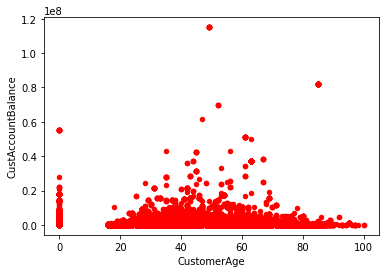

In [46]:
df[['CustAccountBalance', 'CustomerAge']].plot.scatter(x = 'CustomerAge', y = 'CustAccountBalance', c = 'red')


plt.show()

We decided to binning the CustAccountBalance through the qcut function: "The pandas documentation describes qcut as a “Quantile-based discretization function.” This basically means that qcut tries to divide up the underlying data into equal sized bins. The function defines the bins using percentiles based on the distribution of the data, not the actual numeric edges of the bins. "

In [47]:
df['CustAccountBalance'].describe()

count    1.034952e+06
mean     1.150577e+05
std      8.427398e+05
min      0.000000e+00
25%      4.754290e+03
50%      1.682766e+04
75%      5.757180e+04
max      1.150355e+08
Name: CustAccountBalance, dtype: float64

In [48]:
df['CustAccountBalance'].value_counts().sort_index()

0.000000e+00    2595
1.000000e-02     299
2.000000e-02      79
3.000000e-02      44
4.000000e-02      86
                ... 
5.536969e+07      11
6.138221e+07       1
6.979933e+07       4
8.224463e+07      18
1.150355e+08      10
Name: CustAccountBalance, Length: 164951, dtype: int64

We decide to label people with 11 classes of richness, from 0 to 10. The 'richness_0' class contains all the accounts with bank amount less than 3.37 (0-0,01 bin) that could corresponds to people which have inactive account or that do not use too much that bank account. For that reason we decided to group them togheter.

In [49]:
bin_labels = ['richness_0', 'richness_1', 'richness_2', 'richness_3', 'richness_4', 'richness_5', 'richness_6', 'richness_7', 'richness_8', 'richness_9', 'richness_10']

In [50]:
#Use qcut to put into the right bin each value of bank amount creating richness class column 

df['Richness'] = pd.qcut(df['CustAccountBalance'], q = [0,0.01, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], labels = bin_labels)

We need to save the edges values of the bins to use them in part 1.3 of the homework:

In [51]:
query_bins_richness = np.quantile(df['CustAccountBalance'], [0,0.01, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

In [53]:
df.sort_values(by = 'CustAccountBalance', ascending = True)

,New_ID,CustGender,CustomerAge,CustomerClassAge,TransactionAmount (INR),CustAccountBalance,Richness
206988,C2618951F0,F,0,age_0,17196.00,0.0,richness_0
80572,C1622848M23,M,23,age_2,350.00,0.0,richness_0
941651,C8338070M42,M,42,age_6,490.00,0.0,richness_0
427475,C4328426M33,M,33,age_4,1000.00,0.0,richness_0
488009,C4817922M67,M,67,age_11,480.00,0.0,richness_0
...,...,...,...,...,...,...,...
295881,C3316830M49,M,49,age_7,28019.32,115035495.1,richness_10
423744,C4316889M49,M,49,age_7,4364.00,115035495.1,richness_10
244635,C2916887M49,M,49,age_7,600.00,115035495.1,richness_10
908942,C8116818M49,M,49,age_7,3149.00,115035495.1,richness_10


In [54]:
del df['CustAccountBalance']

# 1.1.6 Transaction Amount (INR)

Check the type:

In [55]:
type(df['TransactionAmount (INR)'][0])

numpy.float64

Let's have a look to the distribution of the transaction amount in function of ages:

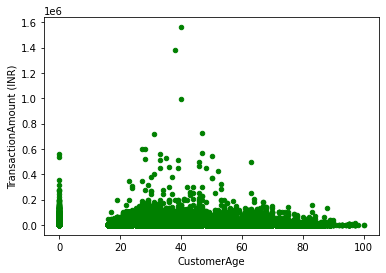

In [56]:
df[['TransactionAmount (INR)', 'CustomerAge']].plot(kind = 'scatter', x= 'CustomerAge', y = 'TransactionAmount (INR)', c = 'green')

plt.show()

In [57]:
df['TransactionAmount (INR)'].describe()

count    1.034952e+06
mean     1.566104e+03
std      6.541172e+03
min      0.000000e+00
25%      1.620000e+02
50%      4.590000e+02
75%      1.200000e+03
max      1.560035e+06
Name: TransactionAmount (INR), dtype: float64

The procedure is the same of the previous point and consists in creating a new column called 'expenditure' in which are inserted the class of 'how much does a user spend'.

In [58]:
bin_labels = ['exp_1', 'exp_2', 'exp_3', 'exp_4', 'exp_5', 'exp_6', 'exp_7', 'exp_8', 'exp_9', 'exp_10']

In [59]:
#Use qcut to create the expenditure column

df['Expenditure'] = pd.qcut(df['TransactionAmount (INR)'], q = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], labels = bin_labels)

We need to save the values of the edges of the bin to insert into them the query in the following point:

In [60]:
query_bins_expenditure = np.quantile(df['TransactionAmount (INR)'], [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

In [62]:
df.head()

,New_ID,CustGender,CustomerAge,CustomerClassAge,TransactionAmount (INR),Richness,Expenditure
0,C1010011F24,F,24,age_2,4750.0,richness_7,exp_10
1,C1010011M33,M,33,age_4,356.0,richness_9,exp_5
2,C1010012M22,M,22,age_2,1499.0,richness_6,exp_8
3,C1010014F24,F,24,age_2,1205.0,richness_7,exp_8
4,C1010014M32,M,32,age_4,250.0,richness_9,exp_4


In [63]:
del df['TransactionAmount (INR)'], df['CustomerAge']

# 1.1.7 Final Dataset

The final result is the following: 

In [64]:
df = df.reset_index(drop = True)
df

,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
0,C1010011F24,F,age_2,richness_7,exp_10
1,C1010011M33,M,age_4,richness_9,exp_5
2,C1010012M22,M,age_2,richness_6,exp_8
3,C1010014F24,F,age_2,richness_7,exp_8
4,C1010014M32,M,age_4,richness_9,exp_4
...,...,...,...,...,...
1034947,C9099836M26,M,age_3,richness_9,exp_7
1034948,C9099877M20,M,age_1,richness_9,exp_4
1034949,C9099919M23,M,age_2,richness_3,exp_3
1034950,C9099941M21,M,age_2,richness_7,exp_1


In [65]:
df.to_csv('data/data.csv', sep = '\t') #save the dataset

# 1.2 Fingerprint hashing

Using the previously selected data with the features you found pertinent, you have to:

Implement your minhash function from scratch. No ready-made hash functions are allowed. Read the class material and search the internet if you need to. For reference, it may be practical to look at the description of hash functions in the book.

Process the dataset and add each record to the MinHash. The subtask's goal is to try and map each consumer to its bin; to ensure this works well, be sure you understand how MinHash works and choose a matching threshold to use. Before moving on, experiment with different thresholds, explaining your choice.

In [65]:
import pandas as pd
from tqdm import tqdm as tq
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [143]:
df = pd.read_csv("data/data.csv", sep = '\t') #load the "cleaned" dataset

In [144]:
df

,Unnamed: 0,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
0,0,C1010011F24,F,age_2,richness_7,exp_10
1,1,C1010011M33,M,age_4,richness_9,exp_5
2,2,C1010012M22,M,age_2,richness_6,exp_8
3,3,C1010014F24,F,age_2,richness_7,exp_8
4,4,C1010014M32,M,age_4,richness_9,exp_4
...,...,...,...,...,...,...
1034947,1034947,C9099836M26,M,age_3,richness_9,exp_7
1034948,1034948,C9099877M20,M,age_1,richness_9,exp_4
1034949,1034949,C9099919M23,M,age_2,richness_3,exp_3
1034950,1034950,C9099941M21,M,age_2,richness_7,exp_1


In [145]:
del df['Unnamed: 0']

# 1.2.1 Shingles

First of all we build the shingles from all the unique values per column in the loaded dataset. We ignore the `TransactionID` column because it is not a shingle.

In [69]:
shingles = [] #initialize shingles
for column_name in df.columns[1:]: 
    shingles += sorted(list(df[column_name].unique())) 
    
shingles.remove('age_0')

#In order to not aggregate people who are labelled with age_0, corresponding to the Customer DOB with year 1800 
#(nan), we decided to remove age_0 from shingles such that those people will not have any 1 in the shingle matrix.
#For that reason they will not be considered similar to anyone for the age, but only for the other fields.

In [70]:
print(shingles)

['F', 'M', 'age_1', 'age_10', 'age_11', 'age_12', 'age_13', 'age_14', 'age_15', 'age_16', 'age_17', 'age_2', 'age_3', 'age_4', 'age_5', 'age_6', 'age_7', 'age_8', 'age_9', 'richness_0', 'richness_1', 'richness_10', 'richness_2', 'richness_3', 'richness_4', 'richness_5', 'richness_6', 'richness_7', 'richness_8', 'richness_9', 'exp_1', 'exp_10', 'exp_2', 'exp_3', 'exp_4', 'exp_5', 'exp_6', 'exp_7', 'exp_8', 'exp_9']


# 1.2.2 Create Shingle Matrix

First of all we create the function which maps each transaction into a vector of 0/1 based on the shingles. 

In [71]:
def one_hot_vector(data, index):
    """Creates a one hot vector for the row found in the data at the given index based on the shingles.
    
    :args
    data - a pandas dataframe containing the data.
    index - an int which corresponds to the row that will be turned into a one hot vector.
    
    :returns
    a numpy array one hot representation of the row
    """
    
    values = data.loc[index][['CustGender', 'CustomerClassAge', 'Richness', 'Expenditure']].values #extract values
    
    indeces = np.where(values.reshape(values.size, 1) == shingles)[1]  #save indexes
    
    vector = np.zeros(len(shingles), dtype = int)  #initialize vector
    
    vector[indeces] = 1  #substitute 1 in the correct positions
    
    return vector

Example:

In [73]:
df.loc[1]

New_ID              C1010011M33
CustGender                    M
CustomerClassAge          age_4
Richness             richness_9
Expenditure               exp_5
Name: 1, dtype: object

In [74]:
print(one_hot_vector(df, 1)) #one hot vector of user C1010011M33

[0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0]


Now we can build a sparse matrix with all the encoded transaction. We don't need to insert into the matrix the name of the Customer cause they are linked to the index of the shingle matrix through the index of the column.  

In [76]:
shingle_matrix = np.zeros((len(df), 40), dtype = int)

for i in tq(range(len(df))):
    # Append the one hot vectors as rows
    shingle_matrix[df.index[i]] = one_hot_vector(df, i) 

# We need to transpose because for the shuffling, the Shingles need to be the rows
shingle_matrix = shingle_matrix.T

100%|███████████████████████████████| 1034952/1034952 [12:49<00:00, 1344.65it/s]


# 1.2.3 Create the Signature Matrix
From the Shingle Matrix, we will now create the signature matrix by doing the following:
1. Shuffle the rows of the Shingle Matrix.
1. Create a vector where each element corresponds to the index of the row of each column (Shingle) where the first 1 is found.
1. Append this vector to the Signature Matrix.
1. Repeat $n$ times.

The goal of the MinHash is to replace a large set with a smaller "signature" that still preserves the underlying similarity metric.

In [80]:
n_permutations = 20 #number of permutations = number of rows of the signature matrix
signature_matrix = np.zeros((20, shingle_matrix.shape[1]), dtype = int) #initialize signature matrix
seed = np.random.randint(0, 100000)
np.random.seed(seed) #set seed for reproducibility

In [81]:
for i in tq(range(n_permutations)):
    # 1. Shuffle rows
    np.random.shuffle(shingle_matrix)
    
    # 2. Create the vector of indeces where the first 1 is found. np.argmax stops at the first occurrence
    signature_row = np.argmax(shingle_matrix == 1, axis=0) + 1
    
    # 3. Add to signature matrix
    signature_matrix[i] = signature_row

100%|███████████████████████████████████████████| 20/20 [00:34<00:00,  1.72s/it]


In [82]:
signature_matrix

array([[17, 14, 16, ..., 16, 16, 16],
       [ 9, 11, 23, ...,  6,  2,  3],
       [ 9, 14, 27, ...,  7, 13, 14],
       ...,
       [ 7, 17,  8, ...,  8,  3, 16],
       [24,  3, 10, ...,  6, 20,  7],
       [ 2,  1,  1, ...,  1,  1,  1]])

In [83]:
signature_matrix.shape

(20, 1034952)

The index of the column can be referred to the customer ID looking at the index of the initial dataframe: 

In [84]:
df

,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
0,C1010011F24,F,age_2,richness_7,exp_10
1,C1010011M33,M,age_4,richness_9,exp_5
2,C1010012M22,M,age_2,richness_6,exp_8
3,C1010014F24,F,age_2,richness_7,exp_8
4,C1010014M32,M,age_4,richness_9,exp_4
...,...,...,...,...,...
1034947,C9099836M26,M,age_3,richness_9,exp_7
1034948,C9099877M20,M,age_1,richness_9,exp_4
1034949,C9099919M23,M,age_2,richness_3,exp_3
1034950,C9099941M21,M,age_2,richness_7,exp_1


For example the first column of the signature matrix is referred to the customer C1010011F24.

# 1.2.4 Divide Signature Matrix into Bands

The example signature matrix below is divided into $b$ bands of $r$ rows each, and each band is hashed separately. For this example, we are setting band , which means that we will consider any titles with the same first two rows to be similar. The larger we make b the less likely there will be another Paper that matches all of the same permutations.

![signature_matrix_into_bands](https://storage.googleapis.com/lds-media/images/locality-sensitive-hashing-lsh-buckets.width-1200.png)

The $\textit{probability}$ that the minhash function for a random permutation of rows produces the $\textbf{same values}$ for two sets is equal to the $\textbf{Jaccard similarity}$ of those sets.


The size of the bands control the probability that two items with a given Jaccard similarity end up in the same bucket. If the number of bands is larger, you will end up with much smaller sets. For instance, $b = p$, where $p$ is the number of permutations (i.e. rows in the signature matrix) would almost certainly lead to $N$ buckets of only one item because there would be only one item that was perfect similar across every permutation.

In order to create the buckets we decide to create a dictionary that will have the sub_vector as keys and the indexes of the column where they are found as values. These indexes will allow us to substistute the related customer:

In [85]:
def create_buckets(b, signature):
    
    indexes = list(range(signature.shape[1])) #create a list of indexes 

    signature_matrix_transposed = signature.T #transpose the matrix to get subvectors column

    cluster = {} #initialize the dictionary containing as keys the subvector and as values the indexes of the customer

    for i in tq(range(0, signature.shape[0], b)):  #iterate over the row with step size equal to bandsize
    
        #take the subvector of dimension i, i+b (band size) from the column
        mini_vectors = signature_matrix_transposed[:, i:i+b] 
    
    # sorts the subvectors associated to the indexes to maintain the relationship with the index of the customers.
    # We use a tuple instead of a list because tuples can be hashable and therefore 
    # usable as keys for dictionaries. Sorting will allow us to have the same subvector as neighbors
    
        c = [(i, tuple(v)) for v, i in sorted(zip(mini_vectors.tolist(), indexes))]
    
        curr_vector = c[0][1] #take the subvector from the tuple composed by index and subvector
    
    #Now we have equal subvector as neighbor, so we can iterate over these groups of equal subvector
        for i, v in c:  
        
            if v not in cluster: #if the subvector is not a key in the cluster --> initialize it 
            
                cluster[v] = []
        
            if curr_vector != v: #when the iteration go over the group of equal subvector updtate the current vector
            
                curr_vector = v

            cluster[v].append(i) #append as values the indexes where that subvector is found 
    
    return cluster

We can create a dictionary containing the buckets with band size 4:

In [86]:
cluster_4 = create_buckets(4, signature_matrix)

100%|█████████████████████████████████████████████| 5/5 [00:26<00:00,  5.34s/it]


We can see that the keys are the subvector:

In [87]:
print(list(cluster_4.keys())[:5])

[(1, 4, 1, 1), (1, 4, 1, 13), (1, 4, 2, 1), (1, 4, 2, 13), (1, 4, 6, 1)]


And the values are the column index where they've been found:

In [88]:
cluster_4[list(cluster_4.keys())[0]][0:5]  #first 5 index referred to the first key of the dictionary:

[810, 4964, 6058, 7325, 9634]

Through them we can recover the name of the customers defining a function that substitute the values of each keys with the 'New_ID' value in the dataframe:

In [89]:
def substitute_keys(buckets, data):
    
    for key in list(buckets.keys()):
    
        buckets[key] = data.loc[buckets[key]]['New_ID'].to_list() #subtitute the indexes with the customers name

    return buckets

In [90]:
cluster_4 = substitute_keys(cluster_4, df)

We can see that now the values of each key are the customer name:

In [91]:
cluster_4[list(cluster_4.keys())[0]][0:5]

['C1012563M20', 'C1024912M20', 'C1028262M20', 'C1032276M20', 'C1039184M20']

We can now visually check how much similar the customer in a bucket are:

In [92]:
df[df['New_ID'].isin(cluster_4[list(cluster_4.keys())[0]])] 

,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
810,C1012563M20,M,age_1,richness_4,exp_4
4964,C1024912M20,M,age_1,richness_4,exp_4
6058,C1028262M20,M,age_1,richness_4,exp_4
7325,C1032276M20,M,age_1,richness_4,exp_4
9634,C1039184M20,M,age_1,richness_4,exp_4
...,...,...,...,...,...
1030000,C9033312M20,M,age_1,richness_4,exp_4
1030481,C9034785M18,M,age_1,richness_4,exp_4
1030514,C9034858M20,M,age_1,richness_4,exp_4
1031887,C9039191M20,M,age_1,richness_4,exp_4


And the number of bucket that we have: 

In [93]:
len(cluster_4)

4798

We can now visually check what happen for $\textbf{band size = 2}$:

In [94]:
cluster_2 = create_buckets(2, signature_matrix) #create buckets with band size 2

cluster_2 = substitute_keys(cluster_2, df) #substitute index with customer names

print('The number of buckets is ', len(cluster_2))

df[df['New_ID'].isin(cluster_2[list(cluster_2.keys())[0]])] #show the member of a bucket as example

100%|███████████████████████████████████████████| 10/10 [01:10<00:00,  7.08s/it]


The number of buckets is  599


,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
5,C1010018F26,F,age_3,richness_1,exp_1
7,C1010028F28,F,age_3,richness_10,exp_6
10,C1010035M24,M,age_2,richness_4,exp_1
19,C1010045M29,M,age_3,richness_4,exp_4
55,C1010157M24,M,age_2,richness_4,exp_1
...,...,...,...,...,...
1034926,C9099142M46,M,age_7,richness_4,exp_9
1034930,C9099183M25,M,age_2,richness_4,exp_1
1034943,C9099740M24,M,age_2,richness_4,exp_6
1034946,C9099832M32,M,age_4,richness_4,exp_6


Decreasing the size of the bands the number of buckets decrease cause are grouped togheter customer that have different values in some fields.

Checking what happen with $\textbf{band size = 5}$:

In [95]:
cluster_5 = create_buckets(5, signature_matrix) #create buckets with band size 2

cluster_5 = substitute_keys(cluster_5, df) #substitute index with customer names

print('The number of buckets is ', len(cluster_5))

df[df['New_ID'].isin(cluster_5[list(cluster_5.keys())[0]])] 

100%|█████████████████████████████████████████████| 4/4 [00:41<00:00, 10.34s/it]


The number of buckets is  6110


,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
810,C1012563M20,M,age_1,richness_4,exp_4
4964,C1024912M20,M,age_1,richness_4,exp_4
6058,C1028262M20,M,age_1,richness_4,exp_4
7325,C1032276M20,M,age_1,richness_4,exp_4
9634,C1039184M20,M,age_1,richness_4,exp_4
...,...,...,...,...,...
1030000,C9033312M20,M,age_1,richness_4,exp_4
1030481,C9034785M18,M,age_1,richness_4,exp_4
1030514,C9034858M20,M,age_1,richness_4,exp_4
1031887,C9039191M20,M,age_1,richness_4,exp_4


There is a larger number of bucket (so a less number of customer per bucket) and the customers have all the same values in the different fields.  

So, the choice of the band size $depends$ on how much similar customer do you want in your bucket. Supposing our request is not too restrictive we can choose $\textbf{4 as band size}$ to execute the query for the next point. 

# 1.3 Locality Sensitive Hashing

Now that you prepared your algorithm, it's query time!
We have prepared some dummy users for you to work with.

Download this csv and report the most similar users (comparing them against the dataset provided in Kaggle).
Did your hashing method work properly, what scores have you obtained and how long did it take to run? Provide information and analysis about the results

# 1.3.1 Pre-processing Query dataset

First of all we need to pre-process the query dataset in the same way we pre-process the initial Kaggle dataset dividing the procedure in the following steps: 

    - Create classes through the ages
    
    - Create classes through the bank amount
    
    - Create classes through the transaction amount
    
    - Create a name for the customers

In [146]:
query = pd.read_csv("query_users/query_users.csv")

In [147]:
query.head()

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,27/7/78,M,DELHI,94695.61,2/9/16,140310,65.0
1,6/11/92,M,PANCHKULA,7584.09,2/9/16,120214,6025.0
2,14/8/91,M,PATNA,7180.60,10/8/16,221732,541.5
3,3/1/87,M,CHENNAI,56847.75,29/8/16,144138,1000.0
4,4/1/95,M,GURGAON,84950.13,25/9/16,233309,80.0


In [148]:
del query['CustLocation'], query['TransactionTime'] #Delete the data that we don't need 

First of all we convert them into class of age, richness and expenditure.

### Customer Class Age

Starting with the age, we used the same procedure of point 1.1:

In [149]:
#In order to calculate the ages we need to transform into datetime birthday and year of the transactions

query['CustomerDOB'] = pd.to_datetime(query['CustomerDOB']) 

query['TransactionDate'] = pd.to_datetime(query['TransactionDate'])

query['CustomerAge'] = 0 #initialize with values zero the ages

#give an age only to queries that have a different YOB from 1800
query.loc[query['CustomerDOB'].dt.year != 1800, 'CustomerAge'] = query.loc[query['CustomerDOB'].dt.year != 1800, 'TransactionDate'].dt.year - query.loc[query['CustomerDOB'].dt.year != 1800, 'CustomerDOB'].dt.year 

In [150]:
query.head(5)

,CustomerDOB,CustGender,CustAccountBalance,TransactionDate,TransactionAmount (INR),CustomerAge
0,1978-07-27,M,94695.61,2016-02-09,65.0,38
1,1992-06-11,M,7584.09,2016-02-09,6025.0,24
2,1991-08-14,M,7180.60,2016-10-08,541.5,25
3,1987-03-01,M,56847.75,2016-08-29,1000.0,29
4,1995-04-01,M,84950.13,2016-09-25,80.0,21


In [151]:
del query['TransactionDate'], query['CustomerDOB'] #deleting the data that we don't need

We $\textit{binned the ages}$ into the same classes of point 1.1, using the function $"\textbf{age}"$: 

In [152]:
bins = np.array(list(range(16, 102, 5)))  #bins

query['CustomerClassAge'] = query.CustomerAge.apply(lambda x: age(x)) #build a new column called class age

In [153]:
del query['CustomerAge'] #deleting the column with the ages

In [154]:
query.head()

,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerClassAge
0,M,94695.61,65.0,age_5
1,M,7584.09,6025.0,age_2
2,M,7180.60,541.5,age_2
3,M,56847.75,1000.0,age_3
4,M,84950.13,80.0,age_2


### Richness

In this case we cannot use the quantiles function 'qcut' to divide into bins the account balance of the customer cause it will be a different results from the classes of the point 1.1. For this reason we used the bins that we saved in point 1.1 and the $\textit{function pd.cut}$ that binned the values with the bins we insert labelling them with the names of the classes. 

In [155]:
bin_labels = ['richness_0', 'richness_1', 'richness_2', 'richness_3', 'richness_4', 'richness_5', 'richness_6', 'richness_7', 'richness_8', 'richness_9', 'richness_10']

We recalled from memory the bins of the classes of richness:

In [157]:
#create the column with the classes of richness:

query['Richness'] = pd.cut(query.CustAccountBalance, bins = query_bins_richness, labels=bin_labels, right=False)

In [158]:
del query['CustAccountBalance'] #deleting the column that we don't need

In [159]:
query.head() #check the result

,CustGender,TransactionAmount (INR),CustomerClassAge,Richness
0,M,65.0,age_5,richness_9
1,M,6025.0,age_2,richness_4
2,M,541.5,age_2,richness_4
3,M,1000.0,age_3,richness_8
4,M,80.0,age_2,richness_9


### Expenditure

We repeated the same procedure of the richness for the expenditure class:

In [161]:
#create the column expenditure

bin_labels = ['exp_1', 'exp_2', 'exp_3', 'exp_4', 'exp_5', 'exp_6', 'exp_7', 'exp_8', 'exp_9', 'exp_10']

query['Expenditure'] = pd.cut(query['TransactionAmount (INR)'], bins = query_bins_expenditure, labels=bin_labels, right=False)

In [162]:
del query['TransactionAmount (INR)'] #deleting the column that we don't need

In [163]:
query.head() #check the result

,CustGender,CustomerClassAge,Richness,Expenditure
0,M,age_5,richness_9,exp_2
1,M,age_2,richness_4,exp_10
2,M,age_2,richness_4,exp_6
3,M,age_3,richness_8,exp_8
4,M,age_2,richness_9,exp_2


### Giving a Name to Query-Customer

The last step that we decided to make is to give a name to this customer -> Query_User_i where i goes from 0 to 49:

In [164]:
#create two column and combine them to create the name:

query['sub'] = 'Query_User_' #prefix

query['num'] = range(50) #numbers

query['New_ID'] = query['sub'] + query['num'].astype(str) #concatenating prefix and number

del query['num'], query['sub'] #deleting the prefix and the numbers

In [165]:
query = query[['New_ID', 'CustGender', 'CustomerClassAge', 'Richness', 'Expenditure']] #reorder the column

In [166]:
query.head() #cheching the result query dataset

,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
0,Query_User_0,M,age_5,richness_9,exp_2
1,Query_User_1,M,age_2,richness_4,exp_10
2,Query_User_2,M,age_2,richness_4,exp_6
3,Query_User_3,M,age_3,richness_8,exp_8
4,Query_User_4,M,age_2,richness_9,exp_2


# 1.3.2 Execute the query

$\textbf{Procedure:}$

To execute the query and return as output the most similar customer to each query we need to do the same MinHash procedure with the same type of shuffling to the rows. Such that the algorithm to divide into bucket is fast (less than 40 seconds) we decided to concatenate the new shingle matrix (shingle query) to the shingle matrix of the initial dataset and to re-execute the bucket-creation procedure. Then we will create a function that takes as input the the name of the query and gives as output the buckets that contain the most similar users to him. 

### Shingle matrix for the query

First of all we define the shingles:

In [167]:
shingles = ['F', 'M', 'age_1', 'age_10', 'age_11', 'age_12', 'age_13', 'age_14', 'age_15', 'age_16', 'age_17', 'age_2', 'age_3', 'age_4', 'age_5', 'age_6', 'age_7', 'age_8', 'age_9', 'richness_0', 'richness_1', 'richness_10', 'richness_2', 'richness_3', 'richness_4', 'richness_5', 'richness_6', 'richness_7', 'richness_8', 'richness_9', 'exp_1', 'exp_10', 'exp_2', 'exp_3', 'exp_4', 'exp_5', 'exp_6', 'exp_7', 'exp_8', 'exp_9']

We build the $\textit{"shingle query"}$ using the 'one_hot_vector' function:

In [168]:
shingle_query = np.zeros((len(query), 40), dtype = int)

for i in tq(range(len(query))):
    # Append the one hot vectors as rows
    shingle_query[query.index[i]] = one_hot_vector(query, i) 

# We need to transpose because for the shuffling, the Shingles need to be the rows
shingle_query = shingle_query.T

100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 1002.42it/s]


An example to see if it worked properly:

In [169]:
query.loc[1]

New_ID              Query_User_1
CustGender                     M
CustomerClassAge           age_2
Richness              richness_4
Expenditure               exp_10
Name: 1, dtype: object

In [170]:
print(shingles)

['F', 'M', 'age_1', 'age_10', 'age_11', 'age_12', 'age_13', 'age_14', 'age_15', 'age_16', 'age_17', 'age_2', 'age_3', 'age_4', 'age_5', 'age_6', 'age_7', 'age_8', 'age_9', 'richness_0', 'richness_1', 'richness_10', 'richness_2', 'richness_3', 'richness_4', 'richness_5', 'richness_6', 'richness_7', 'richness_8', 'richness_9', 'exp_1', 'exp_10', 'exp_2', 'exp_3', 'exp_4', 'exp_5', 'exp_6', 'exp_7', 'exp_8', 'exp_9']


In [171]:
shingle_query[:, 1]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

Then we concatenate the shingle query matrix to the initial shingle matrix: 

In [173]:
new_shingle_matrix = np.concatenate((shingle_matrix, shingle_query), axis = 1) #concatenate the two matrix

In [174]:
new_shingle_matrix.shape

(40, 1035002)

### Create the new signature matrix

Now we can repeat the same MinHash procedure to build the signature matrix: 

In [175]:
n_permutations = 20 #number of permutations = number of rows of the signature matrix

new_signature_matrix = np.zeros((20, new_shingle_matrix.shape[1]), dtype = int) #initialize signature matrix

for i in tq(range(n_permutations)):
    # 1. Shuffle rows
    np.random.shuffle(new_shingle_matrix)
    
    # 2. Create the vector of indeces where the first 1 is found. np.argmax stops at the first occurrence
    signature_row = np.argmax(new_shingle_matrix == 1, axis=0) + 1
    
    # 3. Add to signature matrix
    new_signature_matrix[i] = signature_row


100%|███████████████████████████████████████████| 20/20 [00:34<00:00,  1.70s/it]


To use the "$\textit{substitute_keys}$" function we need to concatenate to the initial dataframe the data related to the query: 

In [176]:
df = df.append(query, ignore_index = True) #append query dataframe to the initial dataframe

In [177]:
df

,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
0,C1010011F24,F,age_2,richness_7,exp_10
1,C1010011M33,M,age_4,richness_9,exp_5
2,C1010012M22,M,age_2,richness_6,exp_8
3,C1010014F24,F,age_2,richness_7,exp_8
4,C1010014M32,M,age_4,richness_9,exp_4
...,...,...,...,...,...
1034997,Query_User_45,F,age_3,richness_10,exp_4
1034998,Query_User_46,M,age_6,richness_6,exp_2
1034999,Query_User_47,M,age_2,richness_10,exp_2
1035000,Query_User_48,F,age_2,richness_4,exp_8


### Buckets creation

We choose the band size b and then we can created the dictionary with the buckets:

In [180]:
cluster_query = create_buckets(4, new_signature_matrix) #create buckets with band size 4

cluster_query = substitute_keys(cluster_query, df) #substitute index with customer names

print('The number of buckets is ', len(cluster_query))

df[df['New_ID'].isin(cluster_query[list(cluster_query.keys())[0]])] #show as example the first group of similar customers

100%|█████████████████████████████████████████████| 5/5 [00:52<00:00, 10.44s/it]


The number of buckets is  4679


,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
6913,C1031019M57,M,age_9,richness_7,exp_8
10075,C1040536F60,F,age_9,richness_7,exp_8
10638,C1042285F60,F,age_9,richness_7,exp_8
17829,C1125238M56,M,age_9,richness_7,exp_8
25721,C1210613F58,F,age_9,richness_7,exp_8
...,...,...,...,...,...
987429,C8721514F56,F,age_9,richness_7,exp_8
1011667,C8917230M57,M,age_9,richness_7,exp_8
1014438,C8925228M56,M,age_9,richness_7,exp_8
1024523,C9017164F59,F,age_9,richness_7,exp_8


### Search the buckets where the query is included

We created a function that takes as $\textbf{input}$ the name of the query (e.g. $\textit{Query_user_35}$) and gives as $\textbf{output}$ the keys of the buckets in which it's contained(e.g. $\textit{Query_user_35: [(1,1,1,2), (1,3,4,3), ...]}$):

In [181]:
def search_bucket(name):
    
    index = [] #initialize the list where will be inserted the keys where the name is found
    
    keys = list(cluster_query.keys()) #list of keys of the dictionary containing the buckets

    values = list(cluster_query.values()) #list of values of the dictionary containing the buckets
    
    #values is a list of lists where the inner contains the values related to the keys.

    for i, v in enumerate(values): # i -> index of the keys, v -> list of values
        
        if name in v:
            
            index.append(keys[i]) #append the keys where the name is found using the index
            
    return index #return the list of keys

Now we decided to create a $\textbf{dictionary}$ where we store as $keys$ the name of the query customer and as $values$ a list of buckets keys where the query customer is inserted. Through them we can find groups of customer similar to the queries: 

In [183]:
# Creation of a dictionary where all the info about the similar users to all the queries all inserted: 

# Keys   -> Query names (e.g. 'Query_User_2', 'Query_User_41', ...)

# Values -> List of keys, i.e. The link to the buckets (e.g. [(9, 4, 8, 12), (21, 20, 19, 10), ...] )

query_buckets = {} #initialize query_bucket

queries_name = list(df.iloc[-50:]['New_ID']) #list of query customer name

for q in queries_name:
    
    query_buckets[q] = search_bucket(q) #keys = query customer name, values = list of bucket where it's found

Example: 

In [186]:
print(query_buckets['Query_User_32'])

[(9, 4, 8, 12), (21, 20, 19, 10), (7, 14, 5, 10), (11, 4, 12, 5), (8, 2, 9, 9)]


The work is done! 

### Find the similar customers gived the query_name

We decided to create a function $\textit{similar_to_query}$ that takes as $\textbf{input}$ the name of the query (e.g. $\textit{Query_User_43})$ and gives as $\textbf{output}$ the components of all the different $\textit{clusters}$ where this users is inserted. In the follow lines we can see an example on how it works:

In [187]:
def similar_to_query(query_name):
    
    keys = query_buckets[query_name] #list of bucket keys of where the name is found
    
    similar_customers = {}  #initialize a dict: keys = name of the group, values = similar customer to the query
    
    for i,k in enumerate(keys):
        
        similar_customers['Group_' + str(i)] = cluster_query[k] #build the dictionary
       
    return similar_customers

In [190]:
similar_to_34 = similar_to_query('Query_User_34')

In [199]:
print(similar_to_34['Group_2'][0:5]) #first 5 components of the second group of similar customer to query_user_34

['C1010876F30', 'C1010921F28', 'C1011387F30', 'C1011643F26', 'C1012035F30']


For example we can take one of the members of a group and compare them to the query user: 

In [192]:
df[df['New_ID'] == 'Query_User_34']

,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
1034986,Query_User_34,M,age_2,richness_10,exp_10


In [193]:
df[df['New_ID'].isin(similar_to_query('Query_User_34')['Group_3'])] 

,New_ID,CustGender,CustomerClassAge,Richness,Expenditure
1034953,Query_User_1,M,age_2,richness_4,exp_10
1034986,Query_User_34,M,age_2,richness_10,exp_10


# 2. Grouping customers together

## Import dataset and data cleaning

In [715]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure
from scipy.spatial.distance import cdist
from random import randint
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from collections import defaultdict
from operator import itemgetter
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import MiniBatchKMeans
from sklearn_extra.robust import RobustWeightedKMeans

In [385]:
df=pd.read_csv(r"data/bank_transactions.csv", sep=",")

We change the following features objects in datetime:
- TransactionTime
- CustomerDOB
- TransactionDate

In [386]:
df['TransactionTime'] = df['TransactionTime'].apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], format = '%d/%m/%y', errors = 'coerce')
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format = '%d/%m/%y', errors = 'coerce')

We create a new feature called 'TransactionDateTime' where we have date and time of a transactions and we remove 'TransactionDate' and 'TransactionTime' so that instead of 2 variables we have 1 that have the same meaning.

In [387]:
def times_to_time_deltas(times):
    return list(map(lambda time: pd.Timedelta(hours=time.hour, minutes=time.minute, seconds=time.second), times))
    
df['TransactionDateTime'] = df.TransactionDate + pd.Series(times_to_time_deltas(df.TransactionTime), index=df.TransactionDate.index)
del df['TransactionDate']
del df['TransactionTime']

In [298]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),TransactionDateTime,TransactionAmountUSD
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,25.00,2016-08-02 14:32:07,0.30
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,27999.00,2016-08-02 14:18:58,335.99
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,459.00,2016-08-02 14:27:12,5.51
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2060.00,2016-08-02 14:27:14,24.72
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,1762.50,2016-08-02 18:11:56,21.15


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   TransactionID            1048567 non-null  object        
 1   CustomerID               1048567 non-null  object        
 2   CustomerDOB              987831 non-null   datetime64[ns]
 3   CustGender               1047467 non-null  object        
 4   CustLocation             1048416 non-null  object        
 5   CustAccountBalance       1046198 non-null  float64       
 6   TransactionDate          1048567 non-null  datetime64[ns]
 7   TransactionTime          1048567 non-null  datetime64[ns]
 8   TransactionAmount (INR)  1048567 non-null  float64       
dtypes: datetime64[ns](3), float64(2), object(4)
memory usage: 72.0+ MB


In [388]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustAccountBalance,1046198.000,115403.540,846485.381,0.000,4721.760,16792.180,57657.360,115035495.100
TransactionAmount (INR),1048567.000,1574.335,6574.743,0.000,161.000,459.030,1200.000,1560034.990


**There are some missing values but very few compering to the rest of the dataset, so we can drop it.**

In [282]:
df.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [389]:
df = df.dropna()

**As we can see, there are a lot of birthdates on January 1st, which seems a little strange. There's also some customers birth on 1/1/1800. This is probably some default the bank has where this information is unknown, althought that is a little strange. Since observations that have CustomerDOB equal to 1/1/1800 are an irrelevant part of the whole dataset, we decided to remove them.**

In [283]:
df['CustomerDOB'].value_counts()

1/1/1800    57339
1/1/89        809
1/1/90        784
6/8/91        699
1/1/91        666
            ...  
3/9/60          1
17/11/52        1
11/9/63         1
28/2/47         1
24/10/44        1
Name: CustomerDOB, Length: 17254, dtype: int64

In [390]:
df = df.loc[~(df['CustomerDOB'] == '1/1/1800')]

**There are people born after 2021, so just subtract 100 from the year of birth of these people.**

In [391]:
df.loc[df['CustomerDOB'].dt.year >= 2021, ['CustomerDOB']] -= pd.DateOffset(years = 100)

**Let's have a look how many male and female we have in our dataset**

In [41]:
df['CustGender'].value_counts()

M    712454
F    272868
Name: CustGender, dtype: int64

Let's plot it with a pie plot

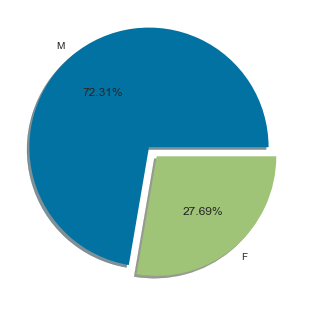

In [88]:
labels = df.CustGender.value_counts().keys()
values = df.CustGender.value_counts().values
explode = (0.1,0)

plt.pie(values,labels=labels,explode=explode,shadow=True,autopct='%1.2f%%');

Now, we want to see the total amount of transactions for females and males and we also want to see the total balance in the female and male accounts.

array([<AxesSubplot:ylabel='CustAccountBalance'>,
       <AxesSubplot:ylabel='TransactionAmount (INR)'>], dtype=object)

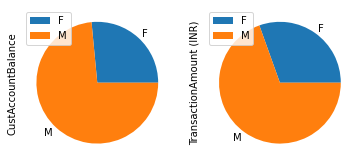

In [54]:
df.groupby(df['CustGender']).sum().plot(kind='pie', subplots=True)

As can be seen from the graphs above, the total amount of transactions of females is not proportional to the total balance of female accounts. In fact, women tend to make higher transactions than men in proportion to their balance.

**Handling the dataset we discovered there are 708 transactions which correspond to an amount of 0**

In [89]:
df[df['TransactionAmount (INR)'] == 0].count()

TransactionID              708
CustomerID                 708
CustomerDOB                708
CustGender                 708
CustLocation               708
CustAccountBalance         708
TransactionAmount (INR)    708
TransactionDateTime        708
dtype: int64

A transaction with an amount of 0 does not make much sense and is perhaps due to some error or some rejected transactions that was recorded anyway. For this reason we drop transactions with an amount equal to 0.

In [392]:
df = df.drop(df[df['TransactionAmount (INR)'] == 0].index,axis = 0)

**Let's see the total amount of transactions for each month**

<AxesSubplot:ylabel='TransactionAmount (INR)'>

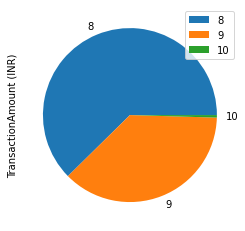

In [56]:
df.groupby(df['TransactionDate'].dt.month).sum().plot(kind='pie', y='TransactionAmount (INR)')

We can therefore see that within the dataset there are only transactions that took place in the months of August, September and October. In particular, most of the transactions were carried out in August.

**Let's now take a look at the ages of the individuals within the dataset.**

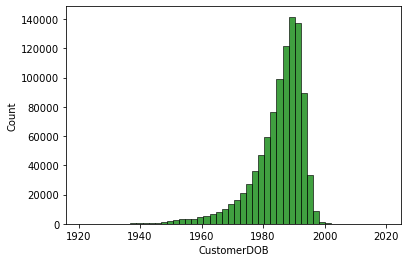

In [70]:
sns.histplot(df.CustomerDOB.dt.year,bins=50, color="green")
plt.show()

It can be seen from the graph that most of the individuals within the dataset in 2016 had an age between 22 to 34 years.

# 2.1 Creating feature engineering

Let's create a new dataframe called new_df. Here we'll create all the features we have to create.

In [393]:
new_df = pd.DataFrame()

**Number of transactions**

In [394]:
new_df['NumTransaction'] = df.groupby(['CustomerID'])['TransactionID'].count()

**Number of transactions > 100 USD**

We are asked to find transactions with an amount greater than 100 USD. Since, the 'TransactionAmount' feature we have is in INR (it would be the Iranian currency), we first create a variable that corresponds to TransactionAmount, but it is in USD, and then we count how many transactions are greater than 100 USD. To convert INR in USD we must consider that 1 INR is equal to 0.012 USD.

In [395]:
df['TransactionAmountUSD'] = df['TransactionAmount (INR)']*0.012
new_df['AmountTrans>100'] = df[df['TransactionAmountUSD']  > 100].groupby(['CustomerID'])['TransactionAmountUSD'].count()
new_df['AmountTrans>100'] = new_df['AmountTrans>100'].fillna(0)
new_df['AmountTrans>100'] = new_df['AmountTrans>100'].astype(int)

**Average amount of transaction**

In [396]:
new_df['AvgAmountTransaction'] = df.groupby(['CustomerID'])['TransactionAmount (INR)'].agg('mean')

**Average balance**

In [397]:
#The first command is to visualize a float number approximated to two decimal places and not an exponential number.
pd.options.display.float_format = '{:.2f}'.format 
new_df['AvgBalance'] = df.groupby(['CustomerID'])['CustAccountBalance'].agg('mean')

**Average difference between the balance and the transaction amount for each customer**

In [398]:
df['provvisoria'] = df['CustAccountBalance'] - df['TransactionAmount (INR)']
new_df['AvgDiffBalTrans'] = df.groupby(['CustomerID'])['provvisoria'].agg('mean')
del df['provvisoria']

**Gender of customers**

In [399]:
#Since within the dataset there is that a CustomerID corresponds to several people (this is probably due to the fact that
#an account can belong to a family and the transactions can be carried out by all the members of the family), we calculate 
#the mode for each CustomerID for the Gender feature, which is the most frequent gender for each CustomerID.
Gender = df.groupby(['CustomerID'])['CustGender'].agg(pd.Series.mode)

#By calculating the fashion it is possible that for a CustomerID it is possible that a female and a male have made the same
#number of transactions. In this case then we simply consider the first value.
for i in Gender.index:
    Gender[i]=Gender[i][0]

#Let's add the new variable to the 'new_df' dataset.
new_df['Gender'] = Gender

**Most frequent location of the customer**

In [400]:
#We calculate the most frequent location by fashion.
frequent_location = df.groupby(['CustomerID'])['CustLocation'].agg(pd.Series.mode)

#Since by doing the mode we can have a situation where the most frequent location is double and in this case a list is
#created that contains both the most frequent locations, so let's do a for loop to replace the list with the first element
#of the list.
l = []
for i in frequent_location.index:
    if type(frequent_location.loc[i])==str:
        l.append(frequent_location[i])
    else:
        l.append(frequent_location[i][0])
        
#Let's add the new variable to the 'new_df' dataset.
new_df["MostFrequentLocation"] = l

## Create 20 additional features

The addictional futures that we will cosider are:

1. Highest transiction amount in USD
2. Lowest transiction amount in USD
3. Highest balance a customer has ever had in USD
4. Lowest balance a customer has ever had in USD
5. Average amount of transactions in USD
6. Average balance in USD
7. Median amount of transactions in USD
7. Number of transaction carried out just during August
8. Number of transaction carried out just during September
9. Number of transaction carried out just during October
10. Age of customers on transition days
11. Number of transactions > 5 USD
12. Number of transactions > 20 USD
13. Number of transactions > 50 USD
14. Number of times a transition has been made in the most frequent location of the customer
15. Number of transitions made in the night (23-06)
16. Number of transitions made in the morning (07-14)
17. Number of transitions made in the evening (15-22)
19. Average time between transactions
20. Season of birthday (Winter, Spring, Summer, Autumn)

**Notation regarding variables 8,9,10**

With regard to variables 8, 9 and 10, at the beginning we thought to see the number of transactions carried out during the 4 different seasons, but later we noticed that the transactions within the dataset were all carried out in the months of August, September and October. For this reason we have decided to create 3 new variables that tell us how many transactions users have made in the different months (August, September and October).

The following cell shows us that the transactions were actually carried out only in the 3 months indicated above.

In [76]:
df.groupby(df['TransactionDate'].dt.month).count()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
TransactionDate,,,,,,,,,
8,613605,613605,613605,613605,613605,613605,613605,613605,613605
9,368307,368307,368307,368307,368307,368307,368307,368307,368307
10,3410,3410,3410,3410,3410,3410,3410,3410,3410


**Notation regarding variables 12,13,14**

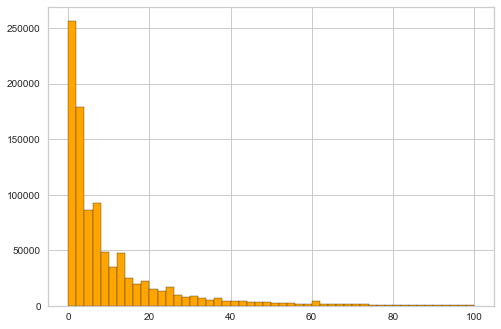

In [618]:
plt.hist(df.TransactionAmountUSD, range=[0,100], bins = 50, color ='orange', edgecolor="black")
plt.show()

In [602]:
#Number of transaction grater than 5 USD
df.TransactionID[df['TransactionAmountUSD'] > 5].count()

499056

In [603]:
#Number of transaction grater than 10 USD
df.TransactionID[df['TransactionAmountUSD'] > 20].count()

174328

In [619]:
#Number of transaction grater than 50 USD
df.TransactionID[df['TransactionAmountUSD'] > 50].count()

60356

We decided to create three new features around the TransactionAmount. In particular, we decided to see transactions greater than 5, 20 and 50. These values were chosen with a criterion: at the beginning we had thought of taking the values 200, 500 and 1000, but within the dataset we noticed that the transactions greater than 200 are very few, so to have more sensible and more distributed features we have taken lower values.

#### Once the additional features considered have been defined, we create them and add them to the 'new_df' dataset.

**1** Highest transiction amount in USD

In [401]:
new_df['MaxAmountTransactionUSD'] = df.groupby(['CustomerID'])['TransactionAmountUSD'].agg('max')

**2** Lowest transiction amount in USD

In [402]:
new_df['MinAmountTransactionUSD'] = df.groupby(['CustomerID'])['TransactionAmountUSD'].agg('min')

**3** Highest balance a customer has ever had in USD

In [403]:
df['CustAccountBalanceUSD'] = df['CustAccountBalance']*0.012
new_df['MaxBalanceUSD'] = df.groupby(['CustomerID'])['CustAccountBalanceUSD'].agg('max')

**4** Lowest balance a customer has ever had in USD

In [404]:
new_df['MinBalanceUSD'] = df.groupby(['CustomerID'])['CustAccountBalanceUSD'].agg('min')

**5** Average amount of transactions in USD

In [405]:
new_df['AvgAmountTransactionUSD'] = df.groupby(['CustomerID'])['TransactionAmountUSD'].agg('mean')

**6** Average balance in USD

In [406]:
pd.options.display.float_format = '{:.2f}'.format 
df['CustAccountBalanceUSD'] = df['CustAccountBalance']*0.012
new_df['AvgBalanceUSD'] = df.groupby(['CustomerID'])['CustAccountBalanceUSD'].agg('mean')

**7** Median amount of transactions in USD

In [407]:
new_df['MedianAmountTransactionUSD'] = df.groupby(['CustomerID'])['TransactionAmountUSD'].agg('median')

**8** Number of transaction carried out just during August

In [408]:
in_august = df[df['TransactionDateTime'].dt.month == 8]
new_df['TransactionAugust'] = in_august.groupby(['CustomerID'])['TransactionDateTime'].count()
new_df['TransactionAugust'] = new_df['TransactionAugust'].fillna(0) #we replace NaN values, that is who didn't make transaction in summer, with 0.
new_df['TransactionAugust'] = new_df['TransactionAugust'].astype(int)

**9** Number of transaction carried out just during September

In [409]:
in_september = df[df['TransactionDateTime'].dt.month == 9]
new_df['TransactionSeptember'] = in_september.groupby(['CustomerID'])['TransactionDateTime'].count()
new_df['TransactionSeptember'] = new_df['TransactionSeptember'].fillna(0) #we replace NaN values, that is who didn't make transaction in summer, with 0.
new_df['TransactionSeptember'] = new_df['TransactionSeptember'].astype(int)

**10** Number of transaction carried out just during October

In [410]:
in_october = df[df['TransactionDateTime'].dt.month == 10]
new_df['TransactionOctober'] = in_october.groupby(['CustomerID'])['TransactionDateTime'].count()
new_df['TransactionOctober'] = new_df['TransactionOctober'].fillna(0) #we replace NaN values, that is who didn't make transaction in summer, with 0.
new_df['TransactionOctober'] = new_df['TransactionOctober'].astype(int)

**11** Age of customers on transition days

In [411]:
ex = df.groupby(['CustomerID'])[['TransactionDateTime','CustomerDOB']].first()
new_df['Age'] = ex['TransactionDateTime'].dt.year - ex['CustomerDOB'].dt.year

**12** Number of transactions > 5 USD

In [412]:
new_df['AmountTrans>5USD'] = df[df['TransactionAmountUSD']  > 5].groupby(["CustomerID"])["TransactionAmountUSD"].count()
new_df['AmountTrans>5USD'] = new_df['AmountTrans>5USD'].fillna(0)
new_df['AmountTrans>5USD'] = new_df['AmountTrans>5USD'].astype(int)

**13** Number of transactions > 20 USD

In [413]:
new_df['AmountTrans>20USD'] = df[df['TransactionAmountUSD']  > 20].groupby(["CustomerID"])["TransactionAmountUSD"].count()
new_df['AmountTrans>20USD'] = new_df['AmountTrans>20USD'].fillna(0)
new_df['AmountTrans>20USD'] = new_df['AmountTrans>20USD'].astype(int)

**14** Number of transactions > 50 USD

In [414]:
new_df['AmountTrans>50USD'] = df[df['TransactionAmountUSD']  > 50].groupby(["CustomerID"])["TransactionAmountUSD"].count()
new_df['AmountTrans>50USD'] = new_df['AmountTrans>50USD'].fillna(0)
new_df['AmountTrans>50USD'] = new_df['AmountTrans>50USD'].astype(int)

**15** Number of times a transition has been made in the most frequent location of the customer

In [415]:
new_df['n_transactions_in_most_freq_loc'] = df.groupby(["CustomerID", "CustLocation"])['CustLocation'].count().max(level=0)

C:\Users\gianl\AppData\Local\Temp\ipykernel_3348\2305568774.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  new_df['n_transactions_in_most_freq_loc'] = df.groupby(["CustomerID", "CustLocation"])['CustLocation'].count().max(level=0)


**16** Number of transitions made in the night (23-06)

In [416]:
after_twentythree = df[df['TransactionDateTime'].dt.hour >= 23]
before_six = df[df['TransactionDateTime'].dt.hour <= 6]
between_twentythree_six = pd.concat([after_twentythree,before_six], ignore_index = True)
new_df['Transaction_23-06'] = between_twentythree_six.groupby(['CustomerID'])['TransactionDateTime'].count()
new_df['Transaction_23-06'] = new_df['Transaction_23-06'].fillna(0) #we replace NaN values, that is who didn't make transaction in summer, with 0.
new_df['Transaction_23-06'] = new_df['Transaction_23-06'].astype(int)

**17** Number of transitions made in the morning (07-14)

In [417]:
after_seven = df[df['TransactionDateTime'].dt.hour >= 7]
between_seven_forteen = after_seven[after_seven['TransactionDateTime'].dt.hour <= 14]
new_df['Transaction_7-14'] = between_seven_forteen.groupby(['CustomerID'])['TransactionDateTime'].count()
new_df['Transaction_7-14'] = new_df['Transaction_7-14'].fillna(0) #we replace NaN values, that is who didn't make transaction in summer, with 0.
new_df['Transaction_7-14'] = new_df['Transaction_7-14'].astype(int)

**18** Number of transitions made in the evening (15-22)

In [418]:
after_fifteen = df[df['TransactionDateTime'].dt.hour >= 15]
between_fifteen_twentytwo = after_fifteen[after_fifteen['TransactionDateTime'].dt.hour <= 22]
new_df['Transaction_15-22'] = between_fifteen_twentytwo.groupby(['CustomerID'])['TransactionDateTime'].count()
new_df['Transaction_15-22'] = new_df['Transaction_15-22'].fillna(0) #we replace NaN values, that is who didn't make transaction in summer, with 0.
new_df['Transaction_15-22'] = new_df['Transaction_15-22'].astype(int)

**19** Average time between transactions

In [419]:
transaction_time_group = df.groupby(['CustomerID'])['TransactionDateTime']
avg_time_between = (transaction_time_group.max() - transaction_time_group.min()) / (transaction_time_group.count() - 1)

For customers with only a single transaction, we would get a `NaT`, so we need to fill it.

In [420]:
avg_time_between.fillna(pd.Timedelta(0), inplace=True)
avg_seconds_between = list(map(lambda td: td.total_seconds(), avg_time_between))

In [421]:
new_df['avg_seconds_between_transactions'] = avg_seconds_between

**20** Season of birthday (Winter, Spring, Summer, Autumn)

In [422]:
def get_season(month):
    """Gets the name of the meteorological season that corresponds to the provided month.
    
    :args
    month (int) - the number of the month. Should be in the interval [1, 12].
    
    :returns
    the name of the meteorological month of the given month. None if the month is outside the interval [1, 12]
    """
    if month in range(1, 3) or month == 12:
        return 'winter'
    if month in range(3, 6):
        return 'spring'
    if month in range(6, 9):
        return 'summer'
    if month in range(9, 12):
        return 'autumn'

In [423]:
birthday_month = df.groupby(['CustomerID'])['CustomerDOB'].first().dt.month

In [424]:
new_df['DOB_season'] = list(map(get_season, birthday_month))

**This is the complete dataset with all 27 features**

In [425]:
new_df.head()

,NumTransaction,AmountTrans>100,AvgAmountTransaction,AvgBalance,AvgDiffBalTrans,Gender,MostFrequentLocation,MaxAmountTransactionUSD,MinAmountTransactionUSD,MaxBalanceUSD,...,Age,AmountTrans>5USD,AmountTrans>20USD,AmountTrans>50USD,n_transactions_in_most_freq_loc,Transaction_23-06,Transaction_7-14,Transaction_15-22,avg_seconds_between_transactions,DOB_season
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,2,0,2553.00,76340.63,73787.63,F,NEW DELHI,57.00,4.27,1442.17,...,24,1,1,1,1,1,1,0,4188344.00,summer
C1010012,1,0,1499.00,24204.49,22705.49,M,MUMBAI,17.99,17.99,290.45,...,22,1,0,0,1,0,0,1,0.00,summer
C1010014,2,0,727.50,100112.95,99385.45,F,MUMBAI,14.46,3.00,1942.19,...,24,1,0,0,2,0,0,2,541094.00,summer
C1010018,1,0,30.00,496.18,466.18,F,CHAMPARAN,0.36,0.36,5.95,...,26,0,0,0,1,0,0,1,0.00,spring
C1010024,1,0,5000.00,87058.65,82058.65,M,KOLKATA,60.00,60.00,1044.70,...,51,1,1,1,1,0,1,0,0.00,summer


# 2.2 Reduce the dimensionality

Since we have a dataset that contains 27 variables, we want to reduce the number of features to work with. To do this, we tried multiple way to find the best one to reduce dimensionality. Not being able to apply a simple PCA as we are dealing with qualitative and quantitative variables, we tried the following ways:
1. Apply Factor Analysis for Mixed Data: This way of proceeding did not require normalization, however trying to apply it, 10 principal components emerged to explain at least 70% of the variance, however we would like to further reduce the dimensionality, so we thought of a other way.


2. Apply the PCA converting all the qualitative variables to make them quantitative (binary for example): in this way the principal components that explain 70% of the variability are 7, so we tried another way to see if we could reduce the dimensionality even more.


3. Apply the PCA by removing the qualitative variables: given that there are only three qualitative variables, namely 'gender', 'MostFrequentLocation' and 'DOB_season', if we eliminate them we see that the main components that explain at least 70% of the variability are 4, so let's go this way!

PCA (Principal Component Analysis) has the advantage of reducing some variables, by removing those that are highly correlated with each other. On the other hand, through PCA some information will be lost and the result will be to have features that are less interpretable.

**Let's go for the third way mantioned above**

So let's create a copy of new_df and then remove the qualitative features that are:
- 'Gender'
- 'MostFrequentLocation'
- 'DOB_season'

In [426]:
new_df2 = new_df.copy()

In [427]:
del new_df2['Gender']
del new_df2['MostFrequentLocation']
del new_df2['DOB_season']

In [428]:
new_df2.head()

,NumTransaction,AmountTrans>100,AvgAmountTransaction,AvgBalance,AvgDiffBalTrans,MaxAmountTransactionUSD,MinAmountTransactionUSD,MaxBalanceUSD,MinBalanceUSD,AvgAmountTransactionUSD,...,TransactionOctober,Age,AmountTrans>5USD,AmountTrans>20USD,AmountTrans>50USD,n_transactions_in_most_freq_loc,Transaction_23-06,Transaction_7-14,Transaction_15-22,avg_seconds_between_transactions
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,2,0,2553.00,76340.63,73787.63,57.00,4.27,1442.17,390.01,30.64,...,0,24,1,1,1,1,1,1,0,4188344.00
C1010012,1,0,1499.00,24204.49,22705.49,17.99,17.99,290.45,290.45,17.99,...,0,22,1,0,0,1,0,0,1,0.00
C1010014,2,0,727.50,100112.95,99385.45,14.46,3.00,1942.19,460.53,8.73,...,0,24,1,0,0,2,0,0,2,541094.00
C1010018,1,0,30.00,496.18,466.18,0.36,0.36,5.95,5.95,0.36,...,0,26,0,0,0,1,0,0,1,0.00
C1010024,1,0,5000.00,87058.65,82058.65,60.00,60.00,1044.70,1044.70,60.00,...,0,51,1,1,1,1,0,1,0,0.00


**To normalize or not to normalize... that is the question.....**

The **choice we make is to normalize** because some units of measurement of the features are different from each other and because the features have a very different variability from each other; normalizing is therefore necessary (we think that in this case it is really mandatory to normalize in order to have PCA results that make sense):

In [429]:
scaler = preprocessing.MinMaxScaler()

In [430]:
new_df_normalized = scaler.fit_transform(new_df2)

In [431]:
new_df_normalized = pd.DataFrame(new_df_normalized, columns = ["NumTransaction","AmountTrans>100","AvgAmountTransaction",
"AvgBalance","AvgDiffBalTrans","MaxAmountTransactionUSD","MinAmountTransactionUSD","MaxBalanceUSD", "MinBalanceUSD",
"AvgAmountTransactionUSD","AvgBalanceUSD","MedianAmountTransactionUSD","TransactionAugust","TransactionSeptember", 
"TransactionOctober", "Age","AmountTrans>5USD", "AmountTrans>20USD", "AmountTrans>50USD","n_transactions_in_most_freq_loc",
"Transaction_23-06", "Transaction_7-14",'Transaction_15-22','avg_seconds_between_transactions'])

In [432]:
def PCAplot(datanorm):
    pca = PCA().fit(datanorm)
    plt.figure(figsize=(10,8))

    # Percentage of variance explained by each principal components
    plt.plot(np.cumsum(pca.explained_variance_ratio_)) 
    plt.hlines(0.7, 0, 24, colors = 'orange')
    plt.xlabel('Number of principal components')
    plt.ylabel('Explained Variance')

    plt.show()

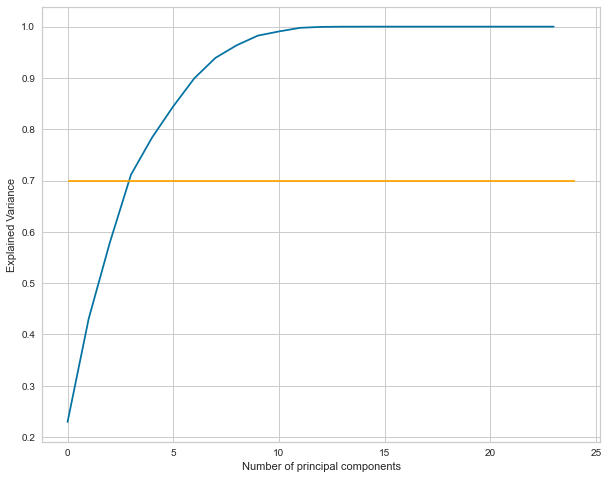

In [433]:
PCAplot(new_df_normalized)

From the graph above it can be seen that the PCA is very efficient, in fact if by absurd we wanted to explain 100% of the variability, from 24 variables we could pass to 11 principal components and not lose any information. However, we are interested in explaining at least 70% of the variance and to do this maybe 4 principal components would suffice (we will see it numerically speaking shortly). However, it can be seen that in the graph, in correspondence with 5 p.c. (actually it is in corrispondence with 4 because the graph on the x axis starts from 0, therefore 4 on the x axis would mean 5 c.p) there seems to be the shape of an elbow and this is a hint from the graph on how many p.c. to take.

### Elbow method

In [434]:
pca = PCA(n_components=10) 
principalcompo = pca.fit_transform(new_df_normalized)

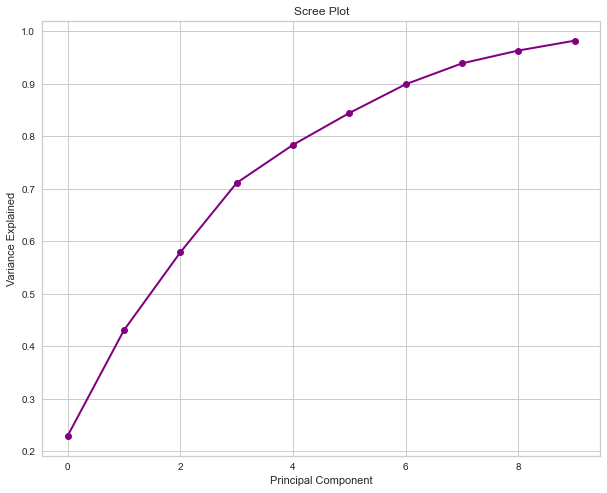

In [435]:
figure(figsize=(10, 8))
PCA_values = np.arange(pca.n_components) 
plt.plot(PCA_values, pca.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='purple')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

As can be seen again from the graph, at 3 (i.e. 4 p.c.) the graph takes on an elbow shape.

Now let's look at how much variance is explained by the principal components and let's choose the number of p.c. to take into account.

In [620]:
pca = PCA(n_components=4) 
principalcompo = pca.fit_transform(new_df_normalized)
pca_df = pd.DataFrame(data = principalcompo)  

In [623]:
print(pca.explained_variance_ratio_.cumsum())

[0.22939115 0.43078268 0.57912457 0.71140402]


In [683]:
print('The variance explained by 4 principal components is: ', sum(pca.explained_variance_ratio_)*100)

The variance explained by 4 principal components is:  71.14040160819222


**In conclusion, given that 4 principal components explain just under 70% of the variance, and given that in correspondence with 4 principal components there is an elbow shape in the graph, 4 principal components are taken.**

In [622]:
pd.options.display.float_format = '{:.3f}'.format 
pca_df.head(10)

,0,1,2,3
0,0.356,0.374,0.089,-0.102
1,0.021,-0.122,-0.100,-0.010
2,0.249,-0.151,-0.206,-0.210
3,-0.082,-0.163,0.158,-0.029
4,0.103,0.261,-0.085,0.290
5,-0.095,0.177,-0.092,0.007
6,0.105,0.136,-0.200,-0.155
7,0.194,0.176,-0.187,-0.291
8,-0.204,0.139,-0.093,-0.034
9,0.301,0.001,-0.090,0.433


Let's rename the column names:

In [642]:
pca_df.rename(columns = {0:'cp1', 1:'cp2', 2:'cp3', 3:'cp4'}, inplace = True)

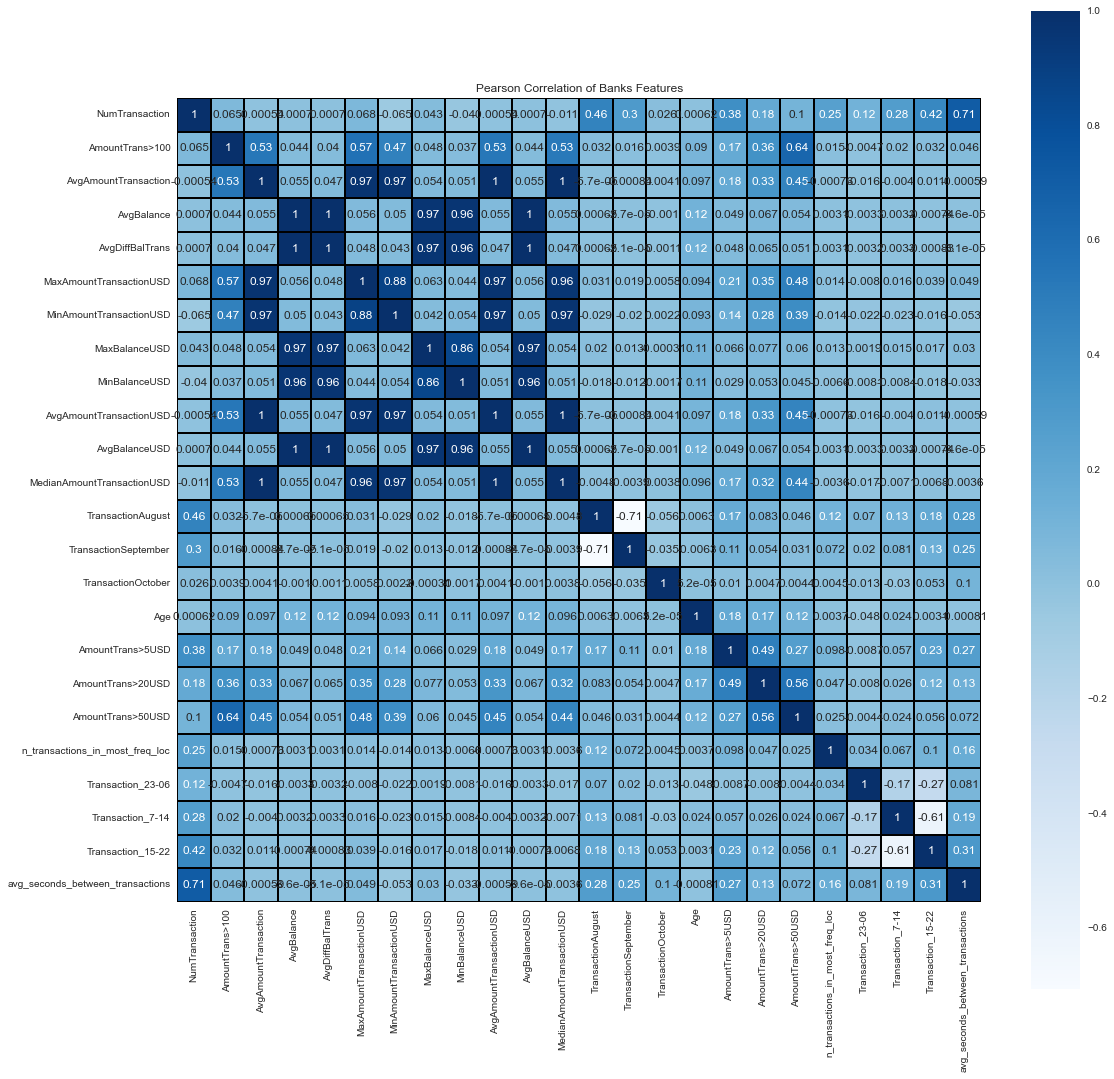

In [442]:
f, ax = plt.subplots(figsize=(18,18))
plt.title('Pearson Correlation of Banks Features')
sns.heatmap(new_df2.astype(float).corr(), linewidths=0.25, vmax=1.0, square=True,
           cmap="Blues", linecolor='black', annot=True)
plt.show()

# 2.3 Clustering

## K-Means using MapReduce

### The idea

The k-means algorithm is generally split into two steps:
1. For each data point, find the closest cluster.
2. Recompute the centroids using the newly assigned data points. 

The idea behind using **MapReduce** for k-means is that both finding the closest centroids for each data point as well as recomputing the centroids, are parallellisable. Finding the closest centroids depends only on the current set of centroids, which does not change until after all closest centroids have been found. Once each point is assigned its closest centroid, recomputing them can also be done in parallel for each centroid.

[source](https://stanford.edu/~rezab/classes/cme323/S16/projects_reports/bodoia.pdf)

### How it works

#### 1. Find closest cluster
This will be the `map` operation in the MapReduce pipeline. During this stage, we will find the index of the closest centroid to a single data point, and return it together with a tuple of the data point and the number 1. The centroid index is the cluster label and the **key** that we will later reduce by. The data point and number 1 are returned so that we can calculate the new centroid after the reduce operation.

$$\texttt{closest_centroid(x)}\\\texttt{emit} \: (argmin_i ||x - \mu_i||^2_2, (x, 1))$$ 

The distance here is the L2 distance squared, but could be replaced with any other distance measure of choice. $\mu_i$ is the $ith$ centroid and we find the cluster label $i$ which minimises the distance between $x$ and $\mu$.

Example output of the **map** phase:
```python
(4, ([ 0.35596249,  0.37370031,  0.08887345, -0.10161327], 1))
```

#### 2. Recompute Centroids
This will be the **reduce** operation in the MapReduce pipeline, though we will only get the final updated centroids **after** the reducing phase. During reducing, we just add up all of the points in each cluster and count how many points we have per cluster. This is why we emitted the 1 in the map phase, it will count the number of points per cluster. 

$$\texttt{sum_points_counts(i, [(p1, c1), (p2, c2)])}\\\texttt{return} \: (p_1 + p_2, c_1 + c_2)$$

We reduce per cluster label $i$. The input will always receive two tuples of `(point, count)` so we just return a new tuple of `(point, count)` that is the element wise sum of the input tuples.

Example output of the **reduce** phase:
```python
(([  1591.70593091,  35802.43836074, -10744.42946682,  15971.76153536]), 207867)
```

Following the **reduce** phase, we can then recompute the centroids by dividing the data point by the number of points in that cluster.

The rest of the steps are like a regular kmeans, we repeat until convergence or until the maximum number of iterations has been reached.

### The Code
The code for kmeans lives in the `clustering` package that we created. We import and run the code after having found the optimum number of clusters using other methods.

## Find an optimal number of clusters

To find the optimal number of clusters we use three methods:
- Elbow method
- InterCluster Distance method
- Calinski harabasz index

### Elbow method

The method consists of plotting the explained variation as a function of the number of clusters and picking the elbow of the curve as the number of clusters to use.

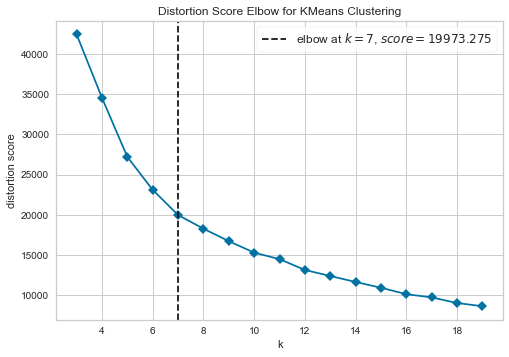

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [444]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,20), timings=False)
visualizer.fit(pca_df)
visualizer.show()

From this plot we can say that the optimal number of cluster is k = 7, because after that the cost function decrese slower and we can see that in k = 7 the graph takes on an elbow shape.

### InterCluster Distance method

Intercluster distance is the distance between two objects belonging to two different clusters. 

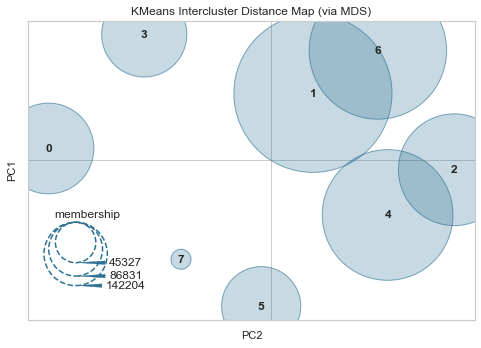

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [292]:
from yellowbrick.cluster import InterclusterDistance

model = KMeans()
visualizer = InterclusterDistance(model)

visualizer.fit(pca_df)   
visualizer.show()

Using the InterCluster Distance method it can be seen that the optimal number of clusters is k = 8.

### Calinski harabasz index

The Calinski harabasz Index is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Here cohesion is estimated based on the distances from the data points in a cluster to its cluster centroid and separation is based on the distance of the cluster centroids from the global centroid.

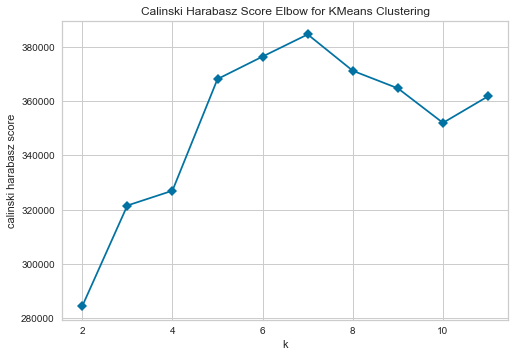

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [625]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12), metric='calinski_harabasz', timings=False, locate_elbow=False)
visualizer.fit(pca_df)
visualizer.show() 

In this case, we must choose the optimal number of clusters based on when the function assumes the maximum value: so the Calinski-Harabasz index suggests to consider 7 cluster.

**How many cluster should we take into account?**

As can be seen from the three methods used above to identify the optimal number of clusters, the **elbow method** suggests taking **7 clusters** into consideration, in fact it can be seen that the graph shows a slight elbow shape at k = 7.
The graph of the **InterCluster Distance method** instead, shows that the optimal number of **clusters** to take is **8**. Contrary to the latter, the graph of the **Calinski-Harabasz index** suggests to take **7 clusters**, in fact it is noted that the maximum score of this index occurs at k = 7.

In conclusion, since two out of three methods used suggest to take into account 7, we choose to take 7 clusters.

**Let's apply the k means implemented by us to our dataset, using the number of clusters indicated by the two methods above**

In [108]:
from clustering import kmeans, closest_centroid
import pyspark

Create spark context and RDD.

In [90]:
sc = pyspark.sql.SparkSession.builder \
                    .appName('kmeans') \
                    .getOrCreate()\
                    .sparkContext
data = sc.parallelize(pca_df)

From the MapReduce kmeans, we get the final centroids. We then need to assign each data point to its closest centroid and get the label of the centroid to add it as a column to the dataframe.

In [ ]:
final_centroids = kmeans(data=data, n_clusters=7, max_iterations=15, threshold=0.1)
cluster_labels = pca_df_cluster.apply(lambda row: closest_centroid(row, final_centroids)[0], axis=1)

We create a copy of the original dataset and add the cluster column to it, which tells us which cluster each observation belongs to.

In [643]:
pca_df_cluster = pca_df.copy()
pca_df_cluster['cluster'] = cluster_labels
pca_df_cluster

,cp1,cp2,cp3,cp4,cluster
0,0.356,0.374,0.089,-0.102,2
1,0.021,-0.122,-0.100,-0.010,3
2,0.249,-0.151,-0.206,-0.210,2
3,-0.082,-0.163,0.158,-0.029,0
4,0.103,0.261,-0.085,0.290,4
...,...,...,...,...,...
838556,-0.072,-0.025,-0.102,0.051,6
838557,-0.209,0.130,0.167,-0.033,5
838558,-0.201,0.141,-0.093,-0.029,5
838559,-0.081,-0.156,-0.102,-0.039,6


Number of observations belonging to each cluster.

In [633]:
pca_df_cluster.cluster.value_counts()

5    211964
0    172677
6    149262
3    134966
2     84900
4     45804
1     38988
Name: cluster, dtype: int64

## K-means++

First of all let's see how many clusters the elbow method suggests if we use kmeans++.

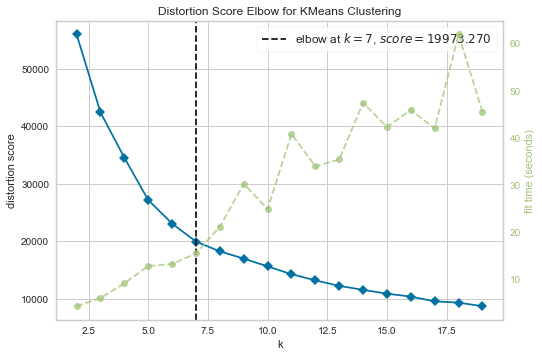

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [458]:
model = KMeans(init='k-means++')
visualizer = KElbowVisualizer(model, k = (2,20), metric = "distortion")
visualizer.fit(pca_df)
visualizer.show()

In general, the substantial difference between k-means and k-means++ lies in the initial choice of the centroids, in fact in the k-means the choice of the centroids is made at random, while in the second, the points that best represent the entire distribution in the space.

In our case, the elbow method of k-means++ compared to that of Kmeans suggests to take into account the same number of clusters, in fact,  as can be seen from the graph the distorsion score after seven clusters decreases more and more slowly, but it is less segmented and this is due to the fact that Kmeans++ reduces the randomness of the Kmans solution so the solution cost drop is cleaner.

In [644]:
cluster1 = KMeans(n_clusters=7, init='k-means++', random_state = 42).fit_predict(pca_df)
pca_df_cluster_plus = pca_df.copy()
pca_df_cluster_plus['cluster'] = cluster1

After creating a new dataset with principal components and clusters column (using k means++), let's see the number of observations belonging to each cluster.

In [638]:
pca_df_cluster_plus.cluster.value_counts()

1    279071
2    168807
0    145232
3     90283
6     55234
4     52497
5     47437
Name: cluster, dtype: int64

First 4 observations with the respective cluster.

In [652]:
pca_df_cluster_plus.head()

,cp1,cp2,cp3,cp4,cluster
0,0.356,0.374,0.089,-0.102,6
1,0.021,-0.122,-0.100,-0.010,1
2,0.249,-0.151,-0.206,-0.210,5
3,-0.082,-0.163,0.158,-0.029,2
4,0.103,0.261,-0.085,0.290,4


The plot below shows the clustered data points for two principal
components, PC1 and PC2. We can see that a majority of points are
bunched up close to the origin, with outgoing bands of data points.
Each band more or less corresponds to a single cluster. There are clusters
that have no or very little variance on either axis, 
e.g. cluster 4 has no or little variance along PC1, but more so along PC2.
This suggests that we have components that don't tell us very much about certain clusters of data.

C:\Users\gianl\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='cp1', ylabel='cp2'>

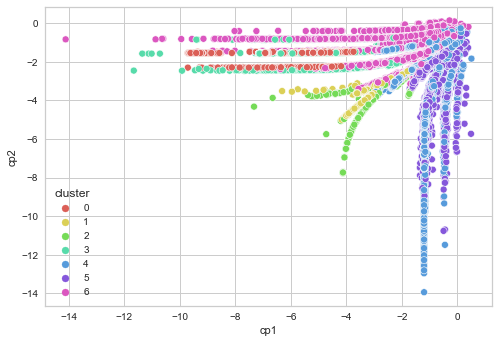

In [648]:
# 2D graph 

unique_values = len(pca_df_cluster_plus["cluster"].unique())

sns.scatterplot(x= np.log(pca_df_cluster_plus.cp1), 
                y= np.log(pca_df_cluster_plus.cp2),
                palette=sns.color_palette('hls', unique_values),
                hue= pca_df_cluster_plus["cluster"])


Let's plot a 3D graph with the axes that refer to the 1°PC, 2°PC and 3°PC.\
Similary to the "d plot, we can be see that wih regard to 1° and 2° PC, the values have a grater variance than that of the 3°PC. Expecially for cluster 3, 4 and 6, in the 3°PC the have a very low variance.

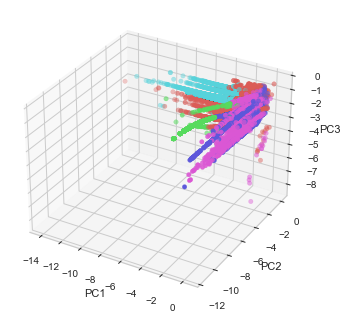

In [651]:
# 3D graph 

unique_values = len(pca_df_cluster_plus["cluster"].unique())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.log(pca_df_cluster_plus.cp1), np.log(pca_df_cluster_plus.cp2), np.log(pca_df_cluster_plus.cp3), 
           c = pca_df_cluster_plus["cluster"],
           cmap = sns.color_palette('hls', unique_values, as_cmap=True))

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.show()


# 2.4 Analysing Results

The variables that we consider relevant to identify the customer cluster are:
- NumTransaction 
- AmountTrans>5USD
- AvgAmountTransaction

To make pivot tables, we create a copy of the dataframe with the 24 variables (the one where we applied the PCA) and add the cluster variable to it, so that we know which cluster each observation belongs to.

In [653]:
new_df2_cluster = new_df2.copy()
new_df2_cluster['cluster'] = cluster

In [654]:
new_df2_cluster.head()

,NumTransaction,AmountTrans>100,AvgAmountTransaction,AvgBalance,AvgDiffBalTrans,MaxAmountTransactionUSD,MinAmountTransactionUSD,MaxBalanceUSD,MinBalanceUSD,AvgAmountTransactionUSD,...,Age,AmountTrans>5USD,AmountTrans>20USD,AmountTrans>50USD,n_transactions_in_most_freq_loc,Transaction_23-06,Transaction_7-14,Transaction_15-22,avg_seconds_between_transactions,cluster
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,2,0,2553.000,76340.635,73787.635,57.000,4.272,1442.166,390.009,30.636,...,24,1,1,1,1,1,1,0,4188344.000,2
C1010012,1,0,1499.000,24204.490,22705.490,17.988,17.988,290.454,290.454,17.988,...,22,1,0,0,1,0,0,1,0.000,3
C1010014,2,0,727.500,100112.950,99385.450,14.460,3.000,1942.185,460.526,8.730,...,24,1,0,0,2,0,0,2,541094.000,2
C1010018,1,0,30.000,496.180,466.180,0.360,0.360,5.954,5.954,0.360,...,26,0,0,0,1,0,0,1,0.000,0
C1010024,1,0,5000.000,87058.650,82058.650,60.000,60.000,1044.704,1044.704,60.000,...,51,1,1,1,1,0,1,0,0.000,4


### Fisrt pivot table (NumTransaction)

How many times a number of transactions have been made by the same customer.

In [664]:
new_df2_cluster['NumTransaction'].value_counts()

1    709823
2    113009
3     14263
4      1352
5       108
6         6
Name: NumTransaction, dtype: int64

Since the NumTransaction variable has 6 unique values, we categorize them into 4 categories:

In category 1 there are individuals who have carried out just one transaction, in category 2 those with two transactions, in category 3 those with three transactions and in category 4 those who have carried out 4-5-6 transactions. We have chosen to make this subdivision because individuals who have carried out 4-5-6 transactions are few compared to those who have carried out fewer, so we have grouped them.


In [655]:
temp1 = pd.cut(new_df2_cluster.NumTransaction,bins=[0.5,1.5,2.5,3.5,6.5],labels=['Category1','Category2','Category3','Category4'])

In [657]:
pd.options.display.float_format = '{:.2f}'.format 
pivot1_cols = ['NumTransaction', 'cluster']

pivot1 = new_df2_cluster[pivot1_cols]

pivot1 = pd.pivot_table(data=pivot1, index=temp1, columns='cluster', aggfunc=len, fill_value=0)

pivot1 = round(pivot1 / pivot1.sum() * 100, 2)

pivot1

NumTransaction                                    
cluster                     0     1     2     3     4     5     6
NumTransaction                                                   
Category1               95.48 74.91  0.00 93.70 85.51 94.83 99.90
Category2                4.50 22.34 83.40  6.30 13.54  5.12  0.10
Category3                0.02  2.59 14.97  0.00  0.91  0.05  0.00
Category4                0.00  0.16  1.63  0.00  0.04  0.00  0.00

As we can see in the pivot table, people belonging to category 1 are present with a high percentage in almost all clusters, however this is due to the fact that 72% of customers have only made 1 transaction. However, we can note that within cluster 2 there are 0 clients who have carried out just one transaction, while in clusters 0, 3, 5 and 6 there are almost only clients who have carried out 1 transaction.

We can therefore conclude that regarding the number of transactions, clusters 1 and 2 are those with individuals who have carried out the most transactions, in particular cluster 2 has no customer who has only made 1 transaction and has almost all customers in category 4. On the other hand, clusters 0, 3, 5 and 6 are almost entirely made up of customers who have only made one transaction.

### Second pivot table (AmountTrans>5USD)

How many times a transaction greater than 5 USD have been made by the same customer.

In [503]:
new_df2_cluster['AmountTrans>5USD'].value_counts()

1    421869
0    379356
2     34948
3      2272
4       105
5        11
Name: AmountTrans>5USD, dtype: int64

Since the AmountTrans>5USD variable (which would be how many times a customer has made a transaction greater than 5 USD) has 6 unique values, we categorize them into 4 categories:

In category 1 there are individuals who have not carried out transactions greater than 5 USD, in category 2 those with one transaction greater than 5 USD, in category 3 those with two transactions greater than five USD and in category 4 those who have carried out 3-4-5 transactions greater than five USD. We have chosen to make this subdivision because individuals who have carried out 3-4-5 transactions are few compared to those who have carried out fewer, so we have grouped them.

In [661]:
temp2 = pd.cut(new_df2_cluster['AmountTrans>5USD'],bins=[-0.5,0.5,1.5,2.5,5.5],labels=['Category1','Category2','Category3','Category4'])

In [663]:
pd.options.display.float_format = '{:.2f}'.format 
pivot2_cols = ['AmountTrans>5USD', 'cluster']

pivot2 = new_df2_cluster[pivot2_cols]

pivot2 = pd.pivot_table(data=pivot2, index=temp2, columns='cluster', aggfunc=len, fill_value=0)

pivot2 = round(pivot2 / pivot2.sum() * 100, 2)

pivot2

AmountTrans>5USD                                    
cluster                         0     1     2     3     4     5     6
AmountTrans>5USD                                                     
Category1                   50.44  0.00 17.67  2.65  0.00 63.39 93.34
Category2                   49.35 83.76 50.00 97.12 93.75 36.61  6.66
Category3                    0.22 15.16 30.13  0.23  6.06  0.00  0.00
Category4                    0.00  1.09  2.21  0.00  0.19  0.00  0.00

As can be seen from the pivot table, cluster 6 contains a large number of individuals (93%) who have carried out zero transactions greater than 5 USD, on the contrary within clusters 1, 3 and 4 there are very few individuals who have carried out 0 transactions greater than 5 USD (0%, 2.65% and 0% respectively). In particular, within clusters 3 and 4 there are mainly customers who have carried out a single transaction. As regards individuals who carry out transactions greater than 5 USD more frequently (3-4-5 times), they are present in large numbers in clusters 1 and 2.

### Third pivot table (AvgAmountTransaction)

How many times an average amount of transactions repeats in customers.

In [576]:
new_df2_cluster['AvgAmountTransaction'].value_counts()

100.000     24186
200.000     21986
50.000      21747
500.000     19686
1000.000    14826
            ...  
1446.725        1
802.510         1
3559.940        1
3290.740        1
856.750         1
Name: AvgAmountTransaction, Length: 102015, dtype: int64

Since the AvgAmountTransaction feature is numeric and continuous, we divide it into 4 categories, taking into consideration the 4 quartiles.

In [665]:
temp3 = new_df2_cluster.copy()
quantiles = np.quantile(new_df2_cluster['AvgAmountTransaction'],q=[0,0.25,0.5,0.75,1])
temp3['AvgAmountTransaction'] = pd.cut(new_df2_cluster['AvgAmountTransaction'], quantiles)

In [666]:
temp3['AvgAmountTransaction'] = temp3['AvgAmountTransaction'].astype('category')

In [667]:
pivot3_cols = ['AvgAmountTransaction', 'cluster']

pivot3 = temp3[pivot3_cols]

pivot3 = pd.pivot_table(data=pivot3, index='AvgAmountTransaction', columns='cluster', aggfunc=len, fill_value=0)

pivot3 = round(pivot3 / pivot3.sum() * 100, 2)

pivot3

cluster,0,1,2,3,4,5,6
AvgAmountTransaction,,,,,,,
"(0.01, 180.0]",26.84,0.00,10.23,1.47,0.00,37.11,50.34
"(180.0, 475.0]",27.28,0.00,26.88,7.79,0.08,29.80,43.51
"(475.0, 1177.2]",26.17,0.01,38.78,49.51,3.01,26.42,4.81
"(1177.2, 1560034.99]",19.71,99.99,24.11,41.22,96.90,6.67,1.33


It can be seen from the pivot table that in clulster 1 and 4 there are almost only individuals belonging to the last quartile, that are customers who have an average transaction amount greater than 1177 INR. In the other hand, within cluster 6 there are mostly customers with an average transaction amount of less than INR 475. As regards cluster 3, 90% of the customers who are within it have an average transaction amount greater than 475 INR. In the other clusters, however, the distribution is homogeneous.

### Use any known metrics to estimate clustering algorithm performance.

To check how well our clusters were formed, we'll use three different metrics:
- calinski-harabasz
- silhouette
- davies-bouldin

**Calinski-harabasz**

Calinski-Harabasz Index is also known as the Variance Ratio Criterion.

The score is defined as the ratio between the within-cluster dispersion and the between-cluster dispersion. The C-H Index is a great way to evaluate the performance of a Clustering algorithm as it does not require information on the ground truth labels.

The higher the Index, the better the performance.

We compute the Calinski-harabasz index for the clusters created by our k-means algorithm created from scratch and for the clusters created by k-means++:

In [693]:

#for k-means
score1 = calinski_harabasz_score(pca_df_cluster, pca_df_cluster.cluster)
print('Calinski-harabasz score: %.3f' % score1)


Calinski-harabasz score: 23624233.069


We obtained a score of 23624233, a very high value which allows us to understand that the clusters we have created have been well formed.

In [694]:

#for k-means++
score1_plus = calinski_harabasz_score(pca_df_cluster_plus, pca_df_cluster_plus.cluster)
print('Calinski-harabasz score: %.3f' % score1_plus)


Calinski-harabasz score: 17673543.140


**Silhouette**

The Silhouette score is between -1 and 1. This score represents how well the data point has been clustered.

The higher the Silhouette Coefficients (the closer to +1), the further away the cluster’s samples are from the neighbouring clusters samples. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighbouring clusters. Negative values, instead, indicate that those samples might have been assigned to the wrong cluster.

We compute the Silhouette score for the clusters created by our k-means algorithm created from scratch and for the clusters created by k-means++.

In [676]:

#for k-means
score2 = silhouette_score(pca_df_cluster, pca_df_cluster.cluster, metric='euclidean')
print('Silhouetter Score: %.3f' % score2)


Silhouetter Score: 0.841


Also in this case, having obtained a value equal to 0.841 (very close to 1), we can state that the clusters we have created are well formed.

In [716]:

#for k-means++
score2_plus = silhouette_score(pca_df_cluster_plus, pca_df_cluster_plus.cluster, metric='euclidean')
print('Silhouetter Score: %.3f' % score2_plus)


Silhouetter Score: 0.849


**Davies-bouldin**

The Davies-Bouldin Index is defined as the average similarity measure of each cluster with its most similar cluster. Similarity is the ratio of within-cluster distances to between-cluster distances. In this way, clusters which are farther apart and less dispersed will lead to a better score.

The minimum score is zero, and differently from most performance metrics, the lower values the better clustering performance.

We compute the Davies-Bouldin score for the clusters created by our k-means algorithm created from scratch and for the clusters created by k-means++.

In [680]:

#for k-means
score3 = davies_bouldin_score(pca_df_cluster, pca_df_cluster.cluster)
print('Davies-bouldin score: %.3f' % score3)


Davies-bouldin score: 0.356


The Davies-bouldin score has a value of 0.356, a very low value and close to 0, so this last metric also tells us that the clusters we have created are well formed.

In [695]:

#for k-means++
score3_plus = davies_bouldin_score(pca_df_cluster_plus, pca_df_cluster_plus.cluster)
print('Davies-bouldin score: %.3f' % score3_plus)


Davies-bouldin score: 0.322


# Bonus Question

The two methods we will use and compare them with the results obtained from k-means and k-means++ are:
-  Mini Batch K-Means
- RobustWeightedKMeans

The **Mini Batch K-means** clustering algorithm is a version of the K-means algorithm which can be used instead of the K-means algorithm when clustering on huge datasets. Sometimes it performs better than the standard K-means algorithm while working on huge datasets because it doesn’t iterate over the entire dataset. It creates random batches of data to be stored in memory, then a random batch of data is collected on each iteration to update the clusters.\
The main advantage of using the Mini-batch K-means algorithm is that it reduces the computational cost of finding a cluster.

The **Robust Weighted K-Means** is an algorithm for robust kmeans clustering using reweighting algorithm.

The **idea of how we want to develop this bonus question** is to find the clusters using the two clustering algorithms mentioned above and then with the Davies-Bouldin score and the Calinski-harabasz index to compare the 4 types of clusters we have found in all question 2 (with: k-means,  k-means++, Mini Batch K-Means and Robust Weighted KMeans) to see which of them formed better clusters.

**Creating cluster with mini bacth k-means algorithm**

In [724]:
pca_df_mini_batch = pca_df.copy()
cluster_mini_batch = MiniBatchKMeans(n_clusters=7, init='k-means++', random_state=0).fit_predict(pca_df)
pca_df_mini_batch["cluster"] = cluster_mini_batch

Let's see the number of observations belonging to each cluster.

In [725]:
pca_df_bonus1.cluster.value_counts()

1    280681
3    169769
6    133000
0     93240
2     83865
5     44458
4     33548
Name: cluster, dtype: int64

**Creating cluster with Robust Weighted KMeans algorithm**

In [719]:
pca_df_robust = pca_df.copy()
cluster_robust = RobustWeightedKMeans(n_clusters=7, random_state=0).fit_predict(pca_df)
pca_df_robust["cluster"] = cluster_robust

In [720]:
pca_df_robust.cluster.value_counts()

1    277011
4    161407
0    147716
5     88914
2     60527
3     58478
6     44508
Name: cluster, dtype: int64

**Comparison with the Calinski-harabasz index for the 4 different types of clusters found**

In [721]:

#for k-means
score1 = calinski_harabasz_score(pca_df_cluster, pca_df_cluster.cluster)
print('Calinski-harabasz score: %.3f' % score1)


Calinski-harabasz score: 23624233.069


In [722]:

#for k-means++
score1_plus = calinski_harabasz_score(pca_df_cluster_plus, pca_df_cluster_plus.cluster)
print('Calinski-harabasz score: %.3f' % score1_plus)


Calinski-harabasz score: 17673543.140


In [726]:

#for mini bacth k-means
score1_mini_batch = calinski_harabasz_score(pca_df_mini_batch, pca_df_mini_batch.cluster)
print('Calinski-harabasz score: %.3f' % score1_mini_batch)


Calinski-harabasz score: 21247578.681


In [727]:

#for Robust Weighted KMeans
score1_robust = calinski_harabasz_score(pca_df_robust, pca_df_robust.cluster)
print('Calinski-harabasz score: %.3f' % score1_robust)


Calinski-harabasz score: 20900673.540


As we can see from the results of the Calinski-harabasz index, the k-means algorithm implemented by us is the one that has a greater value, this means that according to this index, the best formed clusters are those formed with the k- means implemented by us from scratch. As regards the two new methods used, as far as this score tells us, we notice that the clusters formed with the mini-batch k-means are better than those formed with the robust weighted k-means, in fact in the first case a higher Calinski-Harabasz score is obtained (even if only slightly).\
So, to sum up, based on Calinski-harabasz index we get that K-means is a better performing algorithm.

**Comparison with the Davies-bouldin score for the 4 different types of clusters found**

In [728]:

#for k-means
score3 = davies_bouldin_score(pca_df_cluster, pca_df_cluster.cluster)
print('Davies-bouldin score: %.3f' % score3)


Davies-bouldin score: 0.356


In [729]:

#for k-means++
score3_plus = davies_bouldin_score(pca_df_cluster_plus, pca_df_cluster_plus.cluster)
print('Davies-bouldin score: %.3f' % score3_plus)


Davies-bouldin score: 0.322


In [732]:

#for mini bacth k-means
score3_mini_batch = davies_bouldin_score(pca_df_mini_batch, pca_df_mini_batch.cluster)
print('Davies-bouldin score: %.3f' % score3_mini_batch)


Davies-bouldin score: 0.341


In [733]:

#for Robust Weighted KMeans
score3_robust = davies_bouldin_score(pca_df_robust, pca_df_robust.cluster)
print('Davies-bouldin score: %.3f' % score3_robust)


Davies-bouldin score: 0.330


As we can see from the results of the Davies-bouldin score, the k-means++ algorithm is the one that has a lower value, this means that according to this score, the best formed clusters are those formed with the k-means++. As regards the two new methods used, as far as this score tells us, we notice that the clusters formed with the mini-batch k-means are worse than those formed with the robust weighted k-means, indeed in the latter case a lower Davies-bouldin score is obtained (even if only slightly).\
So, to summarize, based on Davies-bouldin score we get that K-means++ is a better performing algorithm.

# Algorithmic Question

## How the algorithm works
There are two possible outcomes of the algorithm:
1. **YES** -> We have enough guards.
2. **NO** -> We don't have enough guards.

### 1. How do we know that we have enough guards?
We know that we have enough guards, if **all** students were able to enter the university.

### 2. How do we know that we don't have enough guards?
We know that we don't have enough guards if we have to remove a guard from a gate that **still** has students waiting.

### Components
From the problem definition, we can identify three components of the algorithm:
1. Gates
2. Students
3. Guards

The diagram below shows the three components for the first example input
```
4 5 1
1 1 3 3 3
```
There are 4 gates (orange), 5 students (green), and 1 guard (blue). The students are queued up in front of their respective gates in ascending order, so that they enter in the correct order. The first two students `1 1`, are labelled `Student 1, Student 2`, and queue in front of gate 1. The next three students, `3 3 3` are labelled `Student 3, Student 4, Student 5`, and are queueing in front of gate 3. There is also a single guard in the guard pool.

![algorithm_overview](docs/algorithmic_question_overview.svg)

## Imports

In [2]:
from domain import Gate
from queue import PriorityQueue

## Read inputs
We will read from a file, in this example for a case where there are enough guards.

In [5]:
file_path = 'data/students_yes.txt'

with open(file_path, 'r') as file:
    n_gates, n_students, n_guards = map(int, file.readline().split())
    student_gates = list(map(int, file.readline().split()))

## 1. Gates
We can think of both the guards and students being assigned to gates. Students need to enter a specific gate and guards need to supervise an assigned gate. For this reason, we decided to create a `Gate` class that will hold students queueing for the gate as well as the guard that is supervising the gate. The class will help to facilitate interactions between all three components and suppor the logic of the overall algorithm. 

Gate class [documentation](https://jonasbarth.github.io/uni/msc/year/1/adm/hw/4/docs/gate.html).

Here, we create a mapping from gate numbers to gates.

In [7]:
gates = {gate_number: Gate(gate_number) for gate_number in range(1, n_gates + 1)}

In [15]:
def are_students_left(gates):
    """Helper method to check whether there are students waiting to be let in at any gate.
    
    :arg
    gates - a list of Gate objects.
    """
    return any(map(lambda gate: not gate.can_be_closed(), gates))   

## 2. Students
This is a list of integers $[1..M]$. Each student (integer) will be placed into a FIFO queue of a gate.

In [8]:
for student, student_gate in zip(range(n_students), student_gates):
    gates[student_gate].add_student(student)

## 3. Guards
We have a pool of $G$ guards that is represented as a list of integers $[1..G]$. We remove a guard from the list when we have a gate where students are waiting but no supervising guard. We add a guard when all students at the gate that the guard is supervising, have been let in.

In [14]:
guards = list(range(1, n_guards + 1))

## Algorithm
### The idea behind the algorithm is that
* we find the gate where the next student will be let in.
* if the gate has a guard, we can let the student in.
* if the gate does not have a guard, we try to assign one. If there are no free guards, we know that don't have enough guards because all guards are supervising gates where students are still waiting.

Here are the steps of the algorithm.
```
while students are waiting to be let in:
    get the gate where the next student will be let in.
    
    if the gate has a guard:
        let in the next student
        
    if the gate has no guard:
        if there are free guards in the pool:
            assign a guard from the pool.
            let in the next student.
            
        if there are no free guards:
            break the loop because all guards are occupied
            
    if the gate has no more students waiting:
        remove guard and put back into the guard pool.
```

In [10]:
queue = PriorityQueue(maxsize=n_gates)
for gate in gates.values():
    queue.put((gate.priority, gate))

students_left = are_students_left(gates.values())

while students_left:
    _, gate = queue.get()

    # If a gate has a guard, I want to let a student in
    if gate.has_guard():
        gate.let_student_in()

    else:
        # If a gate has no guards I need to add a free guard
        if guards:
            guard = guards.pop(0)
            gate.set_guard(guard)
            gate.let_student_in()

        # If there are no free guards at this stage, we don't have enough guards and exit the loop
        else:
            break

    # If no more students are waiting, put the guard back into the pool
    if gate.can_be_closed():
        guards.append(gate.remove_guard())
    
    # Add the gate back into the priority queue with its updated priority
    queue.put((gate.priority, gate))
    
    students_left = are_students_left(gates.values())

if guards:
    print("YES")
else:
    print("NO")

YES


## Space Complexity
Since we have $G$ guards and $M$ students that we store, we have a space complexity of $O(G + M)$.

## Time Complexity

We have a priority queue which we have to build once and then deque $N$ times, one for each gate.

* build once $O(n \: log \: n)$
* deque $n$ items $O(n \: log \: n)$. Dequeing one item takes $O(log \: n)$, since we always pick the first element and have to reorder the queue. 

Hence, we have a time complexity of $O(n \: log \: n)$.